In [1]:
from coffea.nanoevents import NanoEventsFactory
import awkward as ak
import numpy as np



In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import mplhep
# mplhep.set_style(mplhep.style.CMS)

## Kinematics
Below is a plot of all reconstructed electrons' transverse momentum ($p_{T}$) in this NanoAOD file.
Try plotting instead the $\eta$ and $\phi$ of the electrons.  Plot the electron `counts`.  Plot the $p_{T}$ of the electrons after applying a cut on $|\eta| < 1.4$.

NameError: name 'dyevents' is not defined

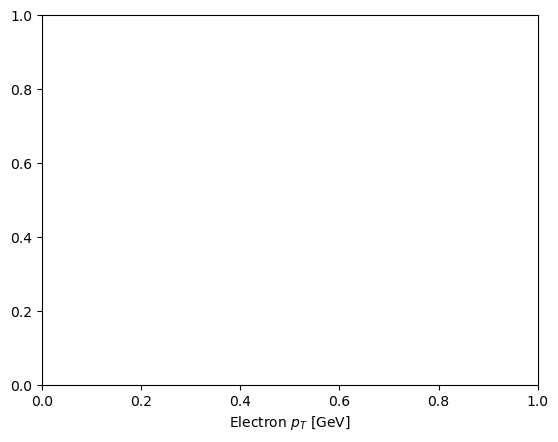

In [3]:
fig, ax = plt.subplots()
ax.set_xlabel(r'Electron $p_{T}$ [GeV]')
ax.hist(ak.flatten(dyevents.Electron.pt), bins=np.linspace(0, 200, 50));

Below we plot the invariant mass of all distinct pairs of electrons. The pairs are selected using the `choose` function. The `i0` and `i1` notation can be used to access the first and second electron in the pair.

NameError: name 'dyevents' is not defined

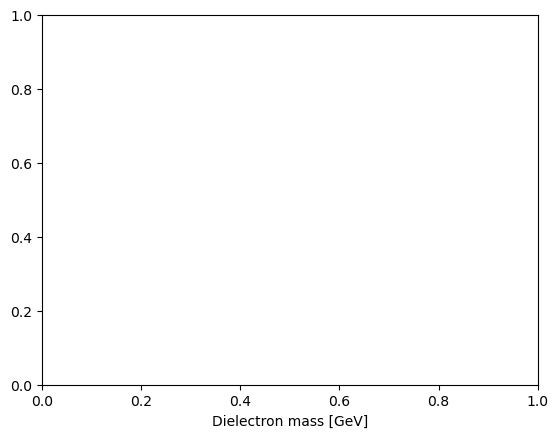

In [4]:
fig, ax = plt.subplots()
ax.set_xlabel(r'Dielectron mass [GeV]')

pairs = ak.combinations(dyevents.Electron, 2, fields=["lep1", "lep2"])
mass = (pairs.lep1 + pairs.lep2).mass
ax.hist(ak.flatten(mass), bins=np.linspace(0, 200, 50));

## Ground truth
If we want to identify variables useful to distinguish true electrons and photons from background, we better have a good definition of "true".  Let's take a look at the generated particles that are matched to reconstructed electrons and photons to understand what kind of processes give rise to them.

For electrons and photons, NanoAOD pre-computes the truth-matched particle by finding final-state electron and photon particles in the `GenPart` table that are spatially close (via the metric $\Delta R = \sqrt{(\Delta \eta)^2 + (\Delta \phi)^2}$) to the reconstructed particle.  When no match is found, we get a null/NA value.  Below, we put reconstructed electrons into three buckets: matched to a gen electron, matched to a gen photon, and unmatched, based on the [PDG id](http://pdg.lbl.gov/2018/reviews/rpp2018-rev-monte-carlo-numbering.pdf).  Since for this purpose we don't care so much which event each electron belongs to, we also flatten the array here for convenience.

In [5]:
electrons = ak.flatten(dyevents.Electron)

true_electrons = electrons[ak.fill_none(abs(electrons.matched_gen.pdgId) == 11, False)]
photon_fakes = electrons[ak.fill_none(electrons.matched_gen.pdgId == 22, False)]
unmatched_electrons = electrons[ak.is_none(electrons.matched_gen)]

NameError: name 'dyevents' is not defined

For the true electrons, we would expected the parent to be a Z boson.  We can inspect this using the `distinctParent` attribute.  There is also a `parent` attribute, which specifies the direct ancestor to the generated electron, however this could also be an electron (due to final state $\gamma$ radiation and other generator-internal reasons).  The `distinctParent` attribute skips copies of the same particle.

Below, we put the distinct parent id, along with some other gen particle flags, into a pandas dataframe by passing a dictionary of `'name': flat_column` pairs to `pd.DataFrame`, and then we use `groupby` to create categories based on the values of each column and count the number of electrons that fall into each category, returning only the top 10 categories.

In [6]:
df = ak.to_pandas(
    ak.zip(
        {
            "parentId": abs(true_electrons.matched_gen.distinctParent.pdgId),
            "fromHardProcess": true_electrons.matched_gen.hasFlags(["fromHardProcess"]),
            "isPrompt": true_electrons.matched_gen.hasFlags(["isPrompt"]),
            "isDirectPromptTauDecayProduct": true_electrons.matched_gen.hasFlags(
                ["isDirectPromptTauDecayProduct"]
            ),
        }
    )
)

top10 = (
    df.groupby(list(df.columns))
    .size()
    .rename("count")
    .reset_index()
    .sort_values("count", ascending=False)
)[:10]

top10

NameError: name 'true_electrons' is not defined

Indeed, in most cases, the parent is pdgId `23`, corresponding to the Z boson.  Sometimes the parent is a $\tau$ lepton, and then the remainder are cases where the electron is from a hadron decay (`parentId > 100`) or where the parentage appears somewhat suspect (e.g. pdg IDs less than 6, corresponding to bare quarks... this is a quirk in how MadGraph records the parentage history for off-shell $Z^*/\gamma^*$)  Luckily, a set of flags is embedded in NanoAOD that are more straightforward than travsersing the NanoAOD parentage history.  In our case, we'll take `isPrompt` as the marker for true electrons coming from the hard scatter event.  Since direct $\tau$ decays produce prompt isolated electrons, we include those with `isDirectPromptTauDecayProduct` as well.

In [7]:
promptmatch = true_electrons.matched_gen.hasFlags(['isPrompt'])
promptmatch = promptmatch | true_electrons.matched_gen.hasFlags(['isDirectPromptTauDecayProduct'])
prompt_electrons = true_electrons[promptmatch]
nonprompt_electrons = true_electrons[~promptmatch]

NameError: name 'true_electrons' is not defined

There is also a pre-computed variable `Electron.genPartFlav`, which according to the documentation, has the assignment:

In [8]:
dyevents.Electron.genPartFlav.__doc__

NameError: name 'dyevents' is not defined

Let's see how this compares to our analysis: below we count the number of occurrences of each flavor using [np.unique](https://docs.scipy.org/doc/numpy/reference/generated/numpy.unique.html) and then print the results.

In [9]:
flavors, counts = np.unique(ak.to_numpy(prompt_electrons.genPartFlav), return_counts=True)
for flavor, count in zip(flavors, counts):
    print("GenPart flavor % 3d has % 8d occurrences" % (flavor, count))

NameError: name 'prompt_electrons' is not defined

Try checking our other categories against this pre-computed ground truth categorization by switching out the `prompt_electrons` variable with the others.
For photons, `gevents.Photon.genPartFlav` provides similar categorization.  Below, we use this variable to sort photons into two variables.

## Discriminating variables
In the following few cells, we'll introduce typical discriminating variables used to distinguish true hard-process electrons and photon from fakes, and plot them.  Later, we'll look at electron- and photon-specific discriminating variables.

### Shower shape

Shower shape variables are constructed from the energy-weighted spatial distribution of ECAL and HCAL deposits.

   * $\sigma_{i\eta i\eta}$ (`Electron.sieie`) is the energy-weighted standard deviation of integer eta (one per crystal) within the 5×5 crystal cluster centered at the crystal with maximum energy:

$$ \sigma_{i\eta i\eta} = \frac{\sum_{i}^{5x5} w_i (i\eta_i - i\eta_{\text{seed}})}{\sum_i^{5x5} w_i}, \quad w_i = \max(0, 4.7 + \ln E_i - \ln E_{5x5}),$$

where the sum runs over the 5 × 5 crystal matrix around the most energetic crystal in the SuperCluster, and the eta distances are measured in units of the crystal size in the eta direction. This variable represents the second moment of the energy distribution along the eta coordinate.  The integer values are scaled by the nominal crystal $\phi$ width in the barrel which is $\pi / 180 \approx 0.0175$.  PS it is defined [here](https://github.com/cms-sw/cmssw/blob/master/RecoEcal/EgammaCoreTools/interface/EcalClusterLazyTools.h#L252) and implemented [here](https://github.com/cms-sw/cmssw/blob/master/RecoEcal/EgammaCoreTools/interface/EcalClusterTools.h#L1034)

   * $R_9$ (`Electron.r9`) is the ratio of the energy deposited in ECAL inside a 3 × 3 crystal matrix centered on the most energetic crystal in the supercluster and the superCluster raw energy.

   * $H/E$ (`Electron.hoe`) is the ratio of the energy deposited in the single closest HCAL tower to the supercluster position inside a cone of radius 0.15 in the $\eta,\phi$ plane centered on the photon direction and the energy deposited in ECAL to that supercluster.

Below, we plot the $\sigma_{i\eta i\eta}$ variable for true prompt electrons and unmatched electrons, where the minimum electron $p_{T}$ is required to be at least 20 GeV.

NameError: name 'prompt_electrons' is not defined

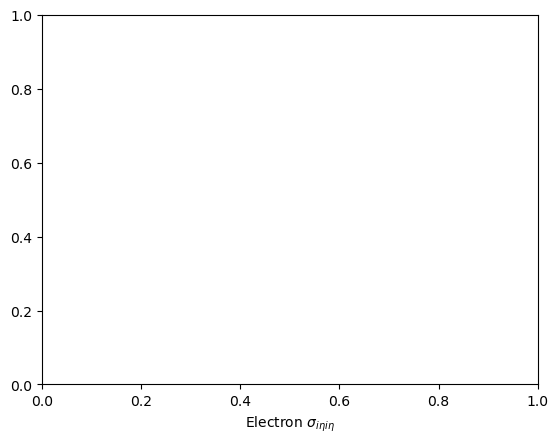

In [6]:
fig, ax = plt.subplots()
ax.set_xlabel(r'Electron $\sigma_{i \eta i \eta}$')
common_opts = {
    'alpha': 0.5,
    'bins': np.linspace(0, 0.05, 100),
    'density': True,
}

def cut(candidates):
    return candidates[
        (candidates.pt > 20.)
    ]

ax.hist(cut(prompt_electrons).sieie, color='blue', label='Prompt electrons', **common_opts)
# ax.hist(cut(photon_fakes).sieie, color='green', label='Photons', **common_opts)
# ax.hist(cut(nonprompt_electrons).sieie, color='orange', label='Non-prompt electrons', **common_opts)
ax.hist(cut(unmatched_electrons).sieie, color='red', label='Unmatched', **common_opts)

ax.legend()
ax.set_ylabel('Normalized' if common_opts['density'] else 'Events');

Try uncommenting different categories and looking at the distributions.  Any guess as to why the true electrons have a double-peak?  It might help to try looking at `sieie` separately for barrel and endcap reconstructed electrons (hint: modify the filter function to also require `abs(electrons.eta) < 1.4447`).

**Duplicate the above cell and look at R9 and H/E variables.**  P.S. both variables have a natural range of 0 to 1.
Which of the three is your favorite?

Look at each variable as a function of $p_{T}$.  Simple option: draw two histograms, one with electron $p_{T} < 20$GeV cut and one with electron $p_{T} > 80$GeV); fancy option: 2D histogram.  What trends do you notice?

Plot `sieie` for prompt and unmatched photons in the barrel.  Notice the double peak for unmatched?

## Isolation

Isolation variables compare the amount of energy deposited in a region around the reconstructed object to that of the object.  Typically, non-prompt electrons and photons (i.e. from hadron decays) have other energy deposited nearby.  Two particle flow (PF) isolation variables are saved in NanoAOD:

   * PF charged hadron isolation `pfRelIso03_chg`: sum of $p_{T}$ of PF charged hadrons which are associated to the primary vertex, not in the "footprint" of the candidate, and within a cone of $\Delta R < 0.3$,
   * PF total isolation `pfRelIso03_all`: sum of $p_{T}$ of all PF candidates within the cone of $\Delta R < 0.3$,
   
where in both cases, the values are relative to the object $p_{T}$.

Due to pileup (multiple collisions in the same event), some of the PF candidates within this isolation cone may belong to a different collision and therefore this variable has a mild dependence on the number of pileup interactions.  A correction is made to the total isolation to remove this pileup-dependence,

$$I = I_{\text{raw}} - \rho * \text{EA}(|\eta|),$$

where $\rho$ is the median pileup energy density per unit area, a measure of the pileup activity in the event (computed during the jet clustering stage with FastJet, acting on the PF candidates); and EA is the effective area of the electron or photon object, a quantity computed and [made available](https://github.com/lsoffi/cmssw/blob/CMSSW_9_2_X_TnP/RecoEgamma/ElectronIdentification/data/Fall17/effAreaElectrons_cone03_pfNeuHadronsAndPhotons_92X.txt) by the Egamma POG, and is defined as explained in [slide 4 here](https://indico.cern.ch/event/662749/contributions/2763091/attachments/1545124/2424854/talk_electron_ID_fall17.pdf).

NameError: name 'prompt_electrons' is not defined

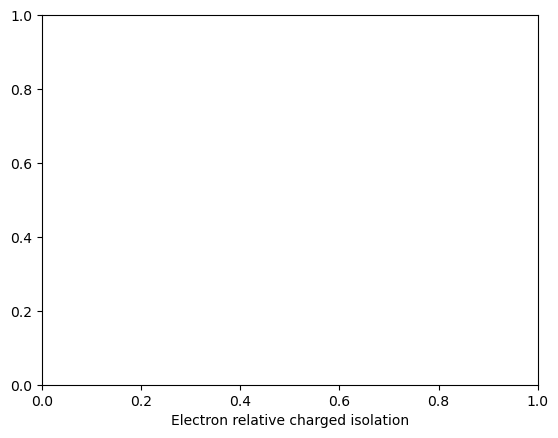

In [7]:
fig, ax = plt.subplots()
ax.set_xlabel(r'Electron relative charged isolation')
common_opts = {
    'alpha': 0.5,
    'bins': np.linspace(0, 1, 100),
    'density': True,
}

ax.hist(prompt_electrons.pfRelIso03_chg, color='blue', label='Prompt electrons', **common_opts)
# ax.hist(photon_fakes.pfRelIso03_chg, color='green', label='Photons', **common_opts)
# ax.hist(nonprompt_electrons.pfRelIso03_chg, color='orange', label='Non-prompt electrons', **common_opts)
ax.hist(unmatched_electrons.pfRelIso03_chg, color='red', label='Unmatched', **common_opts)

ax.legend()
ax.set_yscale('log')
ax.set_ylabel('Normalized' if common_opts['density'] else 'Events');

### Electron-specific variables

   * Mini-isolation `miniPFRelIso_all,miniPFRelIso_chg`: uses a cone whose size varies as a function of the electron $p_{T}$ in order to reduce accidental overlap from hard scatter and pileup processes,
   * Conversion veto `convVeto`: reject photons that converted in the innermost layers of the pixel or tracker detectors

### Photon-specific variables

   * Conversion-safe electron veto `electronVeto`: this cut replaces the detector-based `pixelSeed` used to distinguish between photons and electrons. It checks the $\Delta R$ distance between the photon direction and the nearest electron track and remove photons if there is a GsfElectron matching to the photon supercluster, with no missing hits and having no matching reconstructed conversion.

## Cut optimization

Now that we've seen a few discriminating variables, let's compare their power for differentiating true electrons from background using a [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic), which shows signal tagging efficiency as well as background rejection efficiency simultaneously on a 2D plot. Efficiency $\epsilon$ is defined for a given selection as:

$$\epsilon = \frac{n_{\text{pass}}}{n_{\text{pass}}+n_{\text{fail}}} = \frac{n_{\text{pass}}}{n_{\text{total}}}$$

Below we plot the ROC curve for: selected discriminating variables; working points in the ROC of the POG-supported cut-based ID, which is a tuned selection on multiple variables; and the ROC for the POG-supported MVA classifier. Information on all of the POG-supported IDs can be found [here](https://twiki.cern.ch/twiki/bin/view/CMS/EgammaIDRecipesRun2).

**Define a selection on multiple variables, measure its signal and background efficiency, and place a marker on the ROC corresponding to your ID**

In [8]:
def makeroc(sig, bkg, binning, direction=1):
    '''Given a signal and background discriminant array, along with a binning,
    compute the ROC curve by integrating discriminant histograms along a direction:
        1: cut < value
        -1: cut >= value
    Returns a tuple of (signal efficiency, background efficiency)'''
    sighist, _ = np.histogram(ak.to_numpy(sig), bins=binning)
    bkghist, _ = np.histogram(ak.to_numpy(bkg), bins=binning)
    # numpy histogram will ignore values out of range of our binning (overflow)
    # so add the overflow values that would pass given our cut direction
    if direction == 1:
        sighist[0] += sum(sig < binning[0])
        bkghist[0] += sum(bkg < binning[0])
    elif direction == -1:
        sighist[-1] += sum(sig > binning[-1])
        bkghist[-1] += sum(bkg > binning[-1])
    else:
        raise ValueError("Invalid direction")
    sigpass = (np.cumsum(sighist[::direction]) / len(sig))[::direction]
    bkgpass = (np.cumsum(bkghist[::direction]) / len(bkg))[::direction]
    return (sigpass, bkgpass)


def cut(electrons):
    return electrons[
        (electrons.pt > 20)
        & (abs(electrons.eta) < 1.4)
    ]


roc_sieie = makeroc(
    sig=cut(prompt_electrons).sieie,
    bkg=cut(unmatched_electrons).sieie,
    binning=np.linspace(0.005, 0.02, 50),
    direction=1,
)

roc_hoe = makeroc(
    sig=cut(prompt_electrons).hoe,
    bkg=cut(unmatched_electrons).hoe,
    binning=np.linspace(0., 0.3, 50),
    direction=1,
)

roc_mva = makeroc(
    sig=cut(prompt_electrons).mvaFall17V2Iso,
    bkg=cut(unmatched_electrons).mvaFall17V2Iso,
    binning=np.linspace(-1, 1., 50),
    direction=-1,
)

NameError: name 'prompt_electrons' is not defined

In [9]:
sig_pass = cut(prompt_electrons).cutBased >= prompt_electrons.LOOSE
bkg_pass = cut(unmatched_electrons).cutBased >= prompt_electrons.LOOSE
wp_cutbased_loose = (
    sum(sig_pass) / len(sig_pass),
    sum(bkg_pass) / len(bkg_pass),
)

sig_pass = cut(prompt_electrons).cutBased >= prompt_electrons.TIGHT
bkg_pass = cut(unmatched_electrons).cutBased >= prompt_electrons.TIGHT
wp_cutbased_tight = (
    sum(sig_pass) / len(sig_pass),
    sum(bkg_pass) / len(bkg_pass),
)

NameError: name 'prompt_electrons' is not defined

NameError: name 'roc_sieie' is not defined

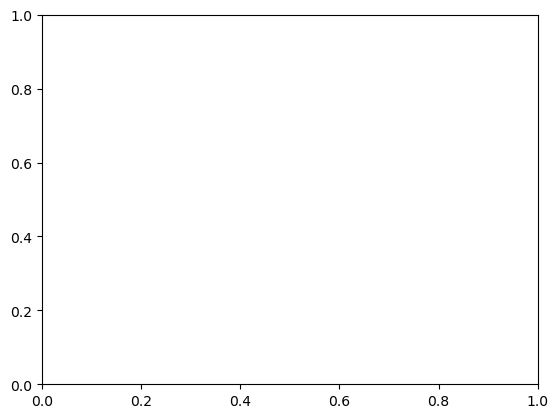

In [10]:
fig, ax = plt.subplots()
ax.plot(*roc_sieie, label=r"Cuts on $\sigma_{i\eta i\eta}$")
ax.plot(*roc_hoe, label=r"Cuts on $H/E$")
ax.plot(*wp_cutbased_loose, label=r"POG loose ID", marker='*', markersize=20, linestyle='none')
ax.plot(*wp_cutbased_tight, label=r"POG tight ID", marker='*', markersize=20, linestyle='none')
ax.plot(*roc_mva, label=r"POG MVA ID")

diag = np.linspace(0, 1, 100)
ax.plot(diag, diag, color='grey', linestyle='--')
ax.set_xlabel("Signal efficiency")
ax.set_ylabel("Background efficiency")
ax.set_xlim(0, 1)
ax.set_ylim(1e-3, 1)
# ax.set_yscale('log')
ax.legend(title=r'Barrel electrons')

We are also often interested in the efficiency as a function of the electron's kinematics. To help explore the dependency, we can record the number of electrons passing and failing a given selection separately for many small regions in the electron $p_{T}$ and $\eta$, which will allow us to compute the (binned) efficiency as a function of these variables, $\epsilon(p_{T}, \eta)$. We are using the [hist](https://hist.readthedocs.io/en/latest/) package to make a multidimensional histogram to record all these values in one object, which later can be projected as necessary.

In [11]:
import hist

efficiency = hist.Hist(
    hist.axis.StrCategory(["pass", "fail"], name="region", label="Region"),
    hist.axis.Regular(18, 20, 200, name="pt", label=r"$p_{T}$"),
    hist.axis.Regular(25, -2.5, 2.5, name="eta", label=r"$\eta$")
)

passing = prompt_electrons.cutBased >= prompt_electrons.TIGHT
efficiency.fill(region="pass", pt=prompt_electrons[passing].pt, eta=prompt_electrons[passing].eta)
efficiency.fill(region="fail", pt=prompt_electrons[~passing].pt, eta=prompt_electrons[~passing].eta)

efficiency

NameError: name 'prompt_electrons' is not defined

In the cell below, we project the histogram to recover the binned $n_{\text{pass}}(p_{T})$ (as `num`) and the binned $n_{\text{total}}(p_{T})$ (as `denom`) and plot the ratio $\epsilon(p_{T})$. Modify which axis the histogram is projected onto to see the efficiency as a function of $\eta$.
**Q: is the efficiency symmetric in $\eta$?**
**Q: what might explain the lower efficiency near $|\eta|=1.4$?**

/home/pursue/mambaforge/lib/python3.10/site-packages/coffea/util.py:154: FutureWarning: In coffea version v2023.3.0 (target date: 31 Mar 2023), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)
/tmp/ipykernel_48/4048857472.py:6: RuntimeWarning: invalid value encountered in divide
  err = abs(clopper_pearson_interval(num, denom) - num / denom)
/tmp/ipykernel_48/4048857472.py:9: RuntimeWarning: invalid value encountered in divide
  mplhep.histplot(num / denom, bins=edges, yerr=err, ax=ax)
/home/pursue/mambaforge/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/pursue/mambaforge/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


Text(0, 0.5, '$\\epsilon$')

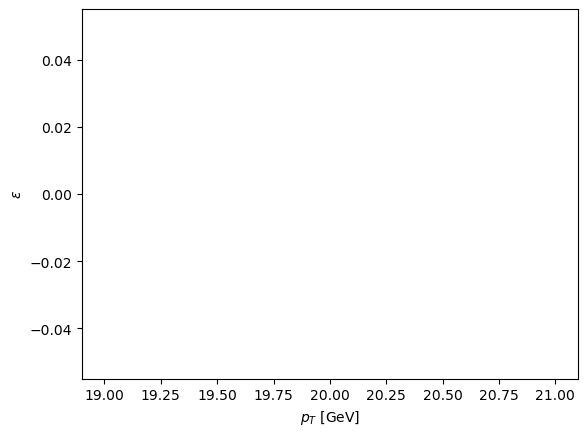

In [12]:
from coffea.hist import clopper_pearson_interval

num = efficiency["pass", ...].project("pt").view()
denom = efficiency.project("pt").view()
edges = efficiency.axes["pt"].edges
err = abs(clopper_pearson_interval(num, denom) - num / denom)

fig, ax = plt.subplots()
mplhep.histplot(num / denom, bins=edges, yerr=err, ax=ax)
ax.set_xlabel("$p_{T}$ [GeV]")
ax.set_ylabel("$\epsilon$")

## Tag and probe

So far, we've computed all our efficiencies using ground truth as provided by our simulation to categorize our signal and background reconstructed electrons.  If we trust our simulation to perfectly describe the detector response, then our job is done.  We cannot do that (**Q: why might we need to know true electron tagging efficiency in data?**), so we need to measure the efficiency in data, categorizing signal and background by inference.  How do we do this without selection bias?  Thanks to the Z boson, we have a solution: tag one electron in an event that passes some high quality requirement, then look for a "probe" electron such that the invariant mass of the di-electron pair ($m_{ee}$) matches that of the Z boson.  If we count the number of probes falling in some mass window that pass and fail our ID, we can infer the true electron tagging efficiency in data, despite not knowing the ground truth for each electron.
Below is a basic example of making a tag and probe selection, then plotting the pass and fail mass distributions, for POG cut-based electron ID, using our simulated Z event sample.

In [13]:
zcands = ak.combinations(dyevents.Electron, 2, fields=["tag", "probe"])
# filter pairs to have a good tag
zcands = zcands[
    (zcands.tag.pt >= 20)
    & (abs(zcands.tag.eta) < 2.1)
    & (zcands.tag.cutBased >= zcands.tag.TIGHT)
]
# filter out events that have no z candidates
zcands = zcands[ak.num(zcands) > 0]
# some events may have multiple candidates, take the leading one (as they are sorted by pt)
zcands = ak.firsts(zcands)

# compute invariant mass of the z
mass = (zcands.tag + zcands.probe).mass

goodprobe = zcands.probe.cutBased >= zcands.probe.LOOSE

NameError: name 'dyevents' is not defined

In [ ]:
fig, (axp, axf) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
mbins = np.linspace(60, 120, 61)

axp.hist(mass[goodprobe], bins=mbins)
axp.set_title('Passing probes')
axp.set_ylabel('Events')
axp.set_xlabel('Dielectron mass [GeV]')

axf.hist(mass[~goodprobe], bins=mbins)
axf.set_title('Failing probes')
axf.set_xlabel('Dielectron mass [GeV]')

Now make the same plot with low and high probe $p_{T}$ requirements.  How does the mass shape and relative peak height change?

**Plot the same distribution for electrons in real data**

Use your DAS skills to find a file from `/EGamma/Run2018A-Nano25Oct2019-v1/NANOAOD` and open it, then make the same selection and plot it.

You'll notice the failing distribution's peak is hidden under a much larger amount of background. This is combinatorial background from random fake electrons combining with the tag to create a continuous falling invariant mass spectrum.  To properly measure the peak height, a full analysis would have to subtract this background by fitting the pass and fail distributions.  If you got this far and are bored, try to use [scipy.optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) to fit each distribution.  Bonus points if you fit them using a simultaneous log likelihood.

If you finish that exercise, figure out what the weather was like in Cessy the day we took the data in that file.  [This page](https://cmsoms.cern.ch/cms/index/index) might be helpful.

In [ ]:
dyevents = NanoEventsFactory.from_root('Downloads/nano10.root').events()
zcands = ak.combinations(dyevents.Electron, 2, fields=["tag", "probe"])
# filter pairs to have a good tag
zcands = zcands[
    (zcands.tag.pt >= 20)
    & (abs(zcands.tag.eta) < 2.1)
    & (zcands.tag.cutBased >= zcands.tag.TIGHT)
]
# filter out events that have no z candidates
zcands = zcands[ak.num(zcands) > 0]
# some events may have multiple candidates, take the leading one (as they are sorted by pt)
zcands = ak.firsts(zcands)
# compute invariant mass
mass = (zcands.tag + zcands.probe).mass

zcands["goodprobe"] = zcands.probe.cutBased >= zcands.probe.TIGHT

In [ ]:
plt.hist(abs(zcands.tag.eta),bins = 50)

#### plt.hist(zcands.probe.mass)
counts, edges, _ = plt.hist(zcands.probe.mass)
#print(counts)
#print(edges)
centers = 0.5*(edges[1:] + edges[:-1])
centers

In [14]:
plt.hist(zcands.probe.pt)
counts1, edges1, _ = plt.hist(zcands.probe.pt)
print(counts1)
print(edges1)
centers1 = 0.5*(edges1[1:] + edges1[:-1])
centers1

NameError: name 'zcands' is not defined

NameError: name 'mass' is not defined

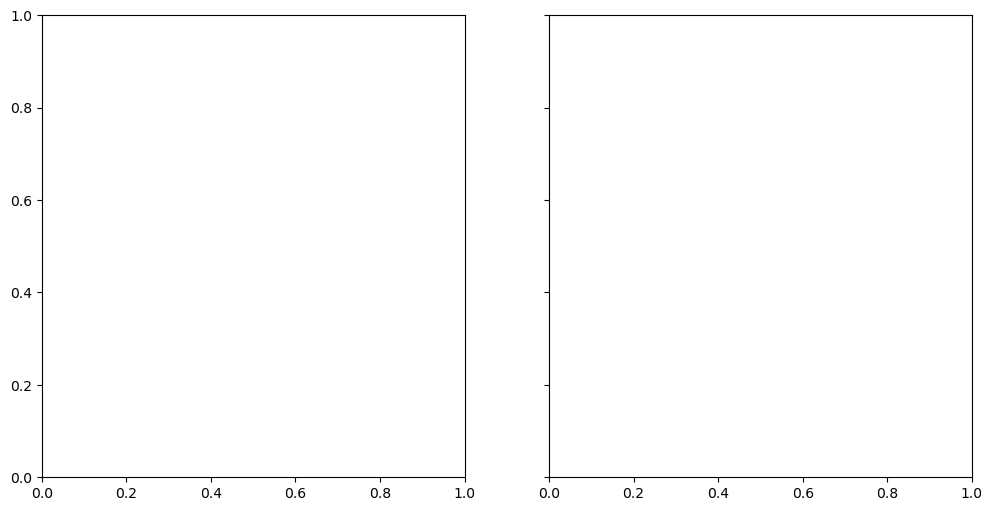

In [15]:
fig, (axp, axf) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
mbins = np.linspace(60, 120, 61)
mcenters =  0.5*(mbins[1:] + mbins[:-1])

counts_pass, _, _ = axp.hist(mass[goodprobe], bins=mbins)
axp.set_title('Passing probes')
axp.set_ylabel('Events')
axp.set_xlabel('Dielectron mass [GeV]')

counts_fail, _, _= axf.hist(mass[~goodprobe], bins=mbins)
axf.set_title('Failing probes')
axf.set_xlabel('Dielectron mass [GeV]')

In [ ]:
plt.rcParams['figure.figsize'] = [6.4, 4.8]

In [16]:
from scipy.stats import poisson
from scipy.integrate import quadrature
from scipy.optimize import minimize

def pdf(x, a, b, c, n, mu, sigma):
    return a + b*x + c*(x**2) + n*np.exp(-0.5*(x-mu)**2/sigma**2)/np.sqrt(2*np.pi)/sigma

#def expected_yields(edges, *param):
    out = np.zeros(len(edges)-1)
    for i, (lo, hi) in enumerate(zip(edges[:-1], edges[1:])):
        out[i], _ = quadrature(pdf, lo, hi, param)
    return out

#def nll(param):
    # negative log likelihood
    exp = np.maximum(0., expected_yields(mbins, *param))
    obs = counts_pass
    return -poisson.logpmf(obs, mu=exp).sum()

p0 = np.array([0, 1, 0, 300, 91., 2.5])
fit = minimize(nll, p0)
#print(fit)
popt = fit.x
pcov = fit.hess_inv

plt.stairs(values=counts_pass, edges=mbins, color="blue", linewidth=5.5, label='data')
plt.stairs(values=expected_yields(mbins, *fit.x), edges=mbins, color="r", linewidth=3.5, label = 'fit')
#plt.stairs(values=expected_yields(mbins, *p0), edges=mbins, color="g", linewidth=3.5, label = 'pre-fit')

plt.legend()


NameError: name 'nll' is not defined

In [17]:
p0_fail = np.array([0, 1, 0, 100, 91., 2.5])
fit_fail = minimize(nll, p0_fail)
popt = fit_fail.x
pcov = fit_fail.hess_inv
plt.stairs(values=counts_fail, edges=mbins, color="blue", linewidth=5.5, label='data')
plt.stairs(values=expected_yields(mbins, *fit_fail.x), edges=mbins, color="r", linewidth=3.5, label = 'fit')
plt.legend()

NameError: name 'nll' is not defined

In [18]:
std = np.sqrt(np.diag(pcov))
correlation = pcov / (std[:, None]*std[None,:])

#fig, ax = plt.subplots()
#im = ax.imshow(correlation, vmin=-1, vmax=1, cmap="bwr")
#fig.colorbar(im)
#ax.set_xticks(np.arange(6), ['a', 'b', 'c', 'n', '$\mu$', '$\sigma$'])
#ax.set_yticks(np.arange(6), ['a', 'b', 'c', 'n', '$\mu$', '$\sigma$'])


NameError: name 'pcov' is not defined

In [19]:
n_pass, n_pass_unc = popt[3], std[3]
print(f"Passing yield: {n_pass}+-{n_pass_unc}")

NameError: name 'popt' is not defined

In [20]:
n_fail, n_fail_unc = popt[3], std[3]
print(f"Failing yield: {n_fail}+-{n_fail_unc}")

NameError: name 'popt' is not defined

In [21]:
from scipy.optimize import curve_fit

xdata = mbins
ydata = np.concatenate([counts_pass, [0]])
p0 = np.array([0, 1, 0, 300, 91., 2.5])
plt.stairs(values=ydata[:-1], edges=xdata, color="blue", linewidth=5.5, label='data')
popt, pcov, *info = curve_fit(func, xdata, ydata, p0=p0, full_output=True)
plt.plot(xdata, func(xdata, *popt), 'r-', linewidth=3.5, label = 'fit')
#plt.plot(xdata, func(xdata, *p0), 'g-', linewidth=3.5, label = 'pre-fit')
plt.legend()




NameError: name 'counts_pass' is not defined

In [22]:
from scipy.optimize import curve_fit
xdata_fail = mbins
ydata_fail = np.concatenate([counts_fail, [0]])
p0 = np.array([0, 1, 0, 100, 91., 2.5])
plt.stairs(values=ydata_fail[:-1], edges=xdata_fail, color="blue", linewidth=5.5, label='data')
popt_fail, pcov_fail, *info = curve_fit(func, xdata_fail, ydata_fail, p0=p0, full_output=True)
plt.plot(xdata_fail, func(xdata_fail, *popt), 'r-', linewidth=3.5, label = 'fit')
#plt.plot(xdata, func(xdata, *p0), 'g-', linewidth=3.5, label = 'pre-fit')


plt.legend()
std_fail = np.sqrt(np.diag(pcov_fail))

NameError: name 'counts_fail' is not defined

In [23]:
"""std = np.sqrt(np.diag(pcov))
correlation = pcov / (std[:, None]*std[None,:])

fig, ax = plt.subplots()
im = ax.imshow(correlation, vmin=-1, vmax=1, cmap="bwr")
fig.colorbar(im)
ax.set_xticks(np.arange(6), ['a', 'b', 'c', 'n', '$\mu$', '$\sigma$'])
ax.set_yticks(np.arange(6), ['a', 'b', 'c', 'n', '$\mu$', '$\sigma$'])
"""

'std = np.sqrt(np.diag(pcov))\ncorrelation = pcov / (std[:, None]*std[None,:])\n\nfig, ax = plt.subplots()\nim = ax.imshow(correlation, vmin=-1, vmax=1, cmap="bwr")\nfig.colorbar(im)\nax.set_xticks(np.arange(6), [\'a\', \'b\', \'c\', \'n\', \'$\\mu$\', \'$\\sigma$\'])\nax.set_yticks(np.arange(6), [\'a\', \'b\', \'c\', \'n\', \'$\\mu$\', \'$\\sigma$\'])\n'

In [24]:
#n_pass, n_pass_unc = popt[3], std[3]
#print(f"Passing yield: {n_pass}+-{n_pass_unc}")

In [25]:
#n_fail, n_fail_unc = popt_fail[3], std_fail[3]
#print(f"failing yield: {n_fail}+-{n_fail_unc}")

In [26]:
#efficiency = (n_pass)/(n_pass + n_fail)

In [27]:
#efficiency


In [28]:
"""from uncertainties import ufloat
from uncertainties.umath import *  # sin(), etc.
x = ufloat(n_pass, n_pass_unc)
y = ufloat(n_fail, n_fail_unc)
eff = x/(x+y)
eff"""

'from uncertainties import ufloat\nfrom uncertainties.umath import *  # sin(), etc.\nx = ufloat(n_pass, n_pass_unc)\ny = ufloat(n_fail, n_fail_unc)\neff = x/(x+y)\neff'

In [3]:
def load_zcands(filename):
    dyevents = NanoEventsFactory.from_root(filename).events()
    zcands = ak.combinations(dyevents.Electron, 2, fields=["tag", "probe"])
    # filter pairs to have a good tag
    zcands = zcands[
        (zcands.tag.pt >= 20)
        & (abs(zcands.tag.eta) < 2.1)
        & (zcands.tag.cutBased >= zcands.tag.TIGHT)
    ]
    # filter out events that have no z candidates
    zcands = zcands[ak.num(zcands) > 0]
    # some events may have multiple candidates, take the leading one (as they are sorted by pt)
    zcands = ak.firsts(zcands)
    zcands["goodprobe"] = zcands.probe.cutBased >= zcands.probe.TIGHT
    return ak.packed(ak.zip({
        "tag_pt": zcands.tag.pt,
        "tag_eta": zcands.tag.eta,
        "tag_phi": zcands.tag.phi,
        "probe_pt": zcands.probe.pt,
        "probe_eta": zcands.probe.eta,
        "probe_phi": zcands.probe.phi,
        "mass": (zcands.tag + zcands.probe).mass,
        "goodprobe": zcands.goodprobe,
    }))

import glob
from tqdm import tqdm
import os

cachefile = "zcands.parquet"
if not os.path.exists(cachefile):
    zcands = ak.concatenate([
        load_zcands(filename)
        for filename in tqdm(glob.glob("Downloads/nano*.root"))
    ])
    ak.to_parquet(zcands, cachefile)
zcands = ak.from_parquet(cachefile)

In [4]:
import gc
gc.collect()

31

In [5]:
"""make a function that takes as inputs two mass arrays, one containing z candidates with a passing probe, 
and the other for failing probes, then the function computes the histograms of each, 
fits them to the function we defined, and computes the efficiency and returns it"""
def tag_eff(pass_mass, fail_mass):
    fig, (axp, axf) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
    
    mbins = np.linspace(60, 120, 61)
    mcenters =  0.5*(mbins[1:] + mbins[:-1])

    counts_pass, _, _ = axp.hist(pass_mass, bins=mbins)
    axp.set_title('Passing probes')
    axp.set_ylabel('Events')
    axp.set_xlabel('Dielectron mass [GeV]')
    axp.axvline(85)
    axp.axvline(98)

    counts_fail, _, _= axf.hist(fail_mass, bins=mbins)
    axf.set_title('Failing probes')
    axf.set_xlabel('Dielectron mass [GeV]')
    axf.axvline(85)
    axf.axvline(98)
    from scipy.stats import crystalball, norm
    #def pdf(x,a,b,c,d):
    
    def pdf(x, a, b, c, n, mu, sigma, d):
        # background = a + b*x + c*(x**2)
        background = np.polyval([a, b, c, d], x)
        signal = n*norm.pdf(x=x, loc=mu, scale=sigma)
        # np.exp(-0.5*(x-mu)**2/sigma**2)/np.sqrt(2*np.pi)/sigma
        return np.maximum(signal + background, 0)
    
    
    from scipy.optimize import curve_fit

    xdata_pass = mbins
    ydata_pass = np.concatenate([counts_pass, [0]])
    npass_guess = np.sum((pass_mass > 80) & (pass_mass < 100))
    p0 = np.array([0, 1, 0, npass_guess, 91., 2.5, 0])
    axp.stairs(values=ydata_pass[:-1], edges=xdata_pass, color="blue", linewidth=5.5, label='data')
    popt_pass, pcov_pass, *info = curve_fit(pdf, xdata_pass, ydata_pass, p0=p0, full_output=True)
    axp.plot(xdata_pass, pdf(xdata_pass, *popt_pass), 'r-', linewidth=3.5, label = 'fit')
    #plt.plot(xdata, func(xdata, *p0), 'g-', linewidth=3.5, label = 'pre-fit')
    plt.legend()
    
    xdata_fail = mbins
    ydata_fail = np.concatenate([counts_fail, [0]])
    nfail_guess = np.sum((fail_mass > 80) & (fail_mass < 100))
    p0 = np.array([0, 1, 0, nfail_guess, 91., 2.5, 0])
    axf.stairs(values=ydata_fail[:-1], edges=xdata_fail, color="blue", linewidth=5.5, label='data')
    popt_fail, pcov_fail, *info = curve_fit(pdf, xdata_fail, ydata_fail, p0=p0, full_output=True)
    axf.plot(xdata_fail, pdf(xdata_fail, *popt_fail), 'r-', linewidth=3.5, label = 'fit')
    #plt.plot(xdata, func(xdata, *p0), 'g-', linewidth=3.5, label = 'pre-fit')

    
    std_fail = np.sqrt(np.diag(pcov_fail))
    std_pass = np.sqrt(np.diag(pcov_pass))
    
    n_pass, n_pass_unc = popt_pass[3], std_pass[3]
    print(f"Passing yield: {n_pass}+-{n_pass_unc}")
    
    n_fail, n_fail_unc = popt_fail[3], std_fail[3]
    print(f"failing yield: {n_fail}+-{n_fail_unc}")
    
    
    
    from uncertainties import ufloat
   #from uncertainties.umath import *  # sin(), etc.
    x = ufloat(n_pass, n_pass_unc)
    y = ufloat(n_fail, n_fail_unc)
    efficiency = x/(x+y)
    print(efficiency*100,"%")
    return efficiency
    


In [6]:
 from uncertainties import ufloat

In [7]:
for lo, hi in zip(ptbins[:-1], ptbins[1:]):
    print(lo, hi)

NameError: name 'ptbins' is not defined

In [9]:
type(10.)

float

[  5.   13.6  16.8  18.8  20.4  21.7  22.9  24.   24.9  25.8  26.7  27.5
  28.2  28.9  29.6  30.3  30.9  31.5  32.   32.6  33.1  33.7  34.2  34.7
  35.1  35.6  36.1  36.5  36.9  37.3  37.8  38.2  38.6  39.   39.3  39.7
  40.1  40.5  40.9  41.2  41.6  42.   42.4  42.8  43.3  43.7  44.2  44.8
  45.6  47.5 303.9]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 3118.5075030728876+-157.17937716085584
failing yield: 6356.220542064041+-290.7471276607414
32.9+/-1.5 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 4641.382442110875+-169.81099040182926
failing yield: 6477.888819816244+-216.63178293283232
41.7+/-1.2 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 4934.325952877482+-172.06646184704556
failing yield: 5580.496241322361+-156.21844812744067
46.9+/-1.1 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 5717.162775065429+-183.4676867334295
failing yield: 4222.758686916172+-186.9777632221364
57.5+/-1.3 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 5548.302997762087+-162.21857688875787
failing yield: 5088.2238873548895+-126.57783477333162
52.2+/-1.0 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 6232.321846761749+-177.77474827315544
failing yield: 5138.271796616356+-137.0718315494771
54.8+/-1.0 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 6269.696915388181+-230.59945980597004
failing yield: 4322.649868719677+-187.47449435513485
59.2+/-1.4 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 5517.82554681914+-179.66828036033365
failing yield: 3840.7680212011155+-150.24554941205628
59.0+/-1.2 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 6405.076218786875+-183.0944918842593
failing yield: 3985.1519680513147+-161.91927067806566
61.6+/-1.2 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 7102.644784547547+-247.99597900434557
failing yield: 3951.4495474145656+-184.30051840764105
64.3+/-1.3 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 6637.888989845252+-183.05776055426466
failing yield: 3588.042517887509+-141.04879722902095
64.9+/-1.1 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 5978.515294321541+-151.62473134148246
failing yield: 3022.390499210328+-117.002912573606
66.4+/-1.0 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 6661.423999645902+-178.20853083729435
failing yield: 3364.171352951971+-146.2892122101379
66.4+/-1.1 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 6695.768126110364+-193.93180775017487
failing yield: 3486.1765224573696+-136.4749073192404
65.8+/-1.1 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 7514.377519488984+-250.60162933976602
failing yield: 3481.7630035254942+-98.73759279750972
68.3+/-0.9 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 6536.913720826022+-163.6191591762343
failing yield: 3229.3473715492582+-122.15763773694968
66.9+/-1.0 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 7227.8326724593835+-173.82015573800842
failing yield: 2962.6349821968643+-124.02074843129701
70.9+/-1.0 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 6226.960787315418+-174.76220539737344
failing yield: 2567.071960793762+-107.86379385343344
70.8+/-1.0 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 7371.575252760993+-189.02806605365078
failing yield: 3171.540670993867+-131.43842624748763
69.9+/-1.0 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 6656.250326673926+-172.86549679178407
failing yield: 2807.972921082941+-118.70330721466229
70.3+/-1.0 %


/var/folders/01/mwjlg00d5kl1_9h6h1d_9kpc0000gn/T/ipykernel_93507/2280316739.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (axp, axf) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 7974.943295769592+-205.1973640478771
failing yield: 3532.224373808716+-178.05813468228664
69.3+/-1.2 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 6905.780870226482+-172.7028808077363
failing yield: 2970.1042449115203+-174.596771524964
69.9+/-1.3 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 6852.730728437291+-188.8129229753761
failing yield: 3204.51641058956+-162.90732824260004
68.1+/-1.3 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 5929.531410435303+-139.71863171626643
failing yield: 2377.9544267628703+-99.59607739214493
71.4+/-1.0 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 7775.015389367217+-192.74932268251888
failing yield: 3269.8111901515827+-134.64149512766983
70.4+/-1.0 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 8004.491904242494+-212.86532388252257
failing yield: 2904.456230200517+-121.19055920970985
73.4+/-1.0 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 6160.250145901233+-188.12728267796325
failing yield: 2772.782379395767+-136.1559602608392
69.0+/-1.2 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 6965.897362846205+-140.41865441286814
failing yield: 2862.8292327733297+-108.66075888560286
70.9+/-0.9 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 6483.353306669911+-167.44740872954972
failing yield: 2765.005459157977+-98.75426502577487
70.1+/-0.9 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 8177.189017756413+-227.7828165161295
failing yield: 3605.838125053203+-132.71123369403307
69.4+/-1.0 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 7318.830794783305+-202.25838375221346
failing yield: 2287.757753790476+-107.5931400960923
76.2+/-1.0 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 6899.928465004202+-178.82826117883704
failing yield: 2479.0600748927845+-141.35234985302827
73.6+/-1.2 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 7452.193917683306+-160.74804216484245
failing yield: 2450.4314303765923+-108.09993517525412
75.3+/-0.9 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 5927.55647724669+-157.84989036465865
failing yield: 1631.7405674410054+-91.33813583862919
78.4+/-1.0 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 7424.349624246835+-139.79459593993286
failing yield: 2634.009180804894+-99.70284569047273
73.8+/-0.8 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 7152.646500664607+-180.8031768790663
failing yield: 2639.8397302345857+-104.42863316946287
73.0+/-0.9 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 7792.813083934265+-231.41909583190264
failing yield: 2543.646304929904+-116.7623158773942
75.4+/-1.0 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 7081.907868601114+-193.31834747431876
failing yield: 2245.029465193098+-149.76896873983705
75.9+/-1.3 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 4897.1964278946225+-138.81591515064792
failing yield: 1922.6277777244147+-102.05644277481555
71.8+/-1.2 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 6763.570150261387+-253.06041469385363
failing yield: 2342.5030656605527+-154.5955938262642
74.3+/-1.4 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 7441.07654897424+-197.49378121709591
failing yield: 2572.1926513067556+-123.22961753082382
74.3+/-1.0 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 8001.00695950519+-211.97277788300124
failing yield: 3483.902459352776+-70.12917462561418
69.7+/-0.7 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 8225.593408011113+-213.52224509433498
failing yield: 2962.5466088332732+-100.00104807278503
73.5+/-0.8 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 10502.940297494903+-142.34808902314805
failing yield: 3275.815934144108+-119.31328339722535
76.2+/-0.7 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 7766.897015616719+-134.33479258563784
failing yield: 2208.803583171456+-79.59790512261827
77.9+/-0.7 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 9306.29424585691+-282.30853834333243
failing yield: 2885.9939005864558+-95.1721810787051
76.3+/-0.8 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 8538.041724644298+-285.4117450353222
failing yield: 2674.790564823218+-88.5298885802324
76.1+/-0.9 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 6924.311163737933+-303.45007648851686
failing yield: 2494.354589162732+-127.4095722624412
73.5+/-1.3 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 7282.151192218763+-285.7380767981848
failing yield: 2577.348731790809+-88.37815840490371
73.9+/-1.0 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Passing yield: 5502.625921673879+-146.03762896463766
failing yield: 1432.05845280107+-57.57069177226033
79.3+/-0.8 %


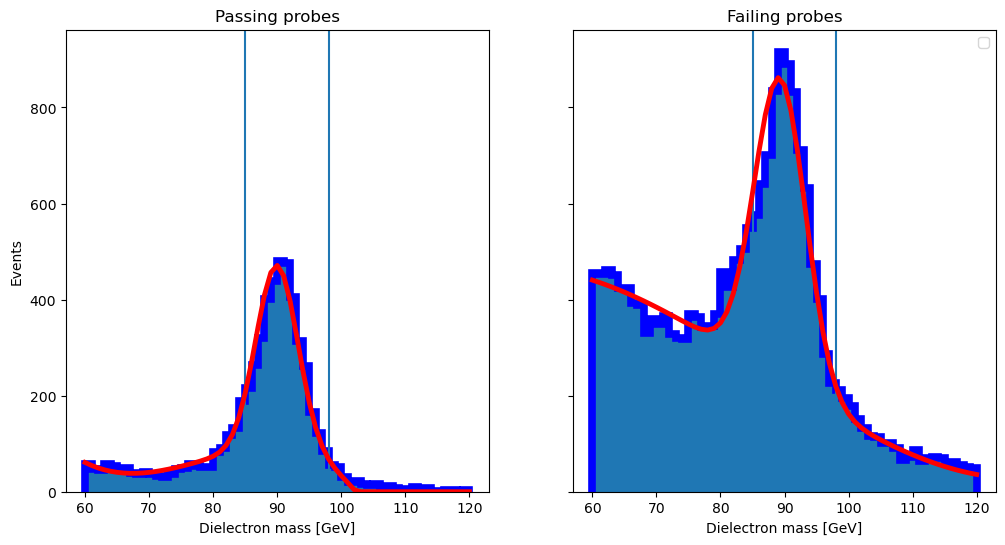

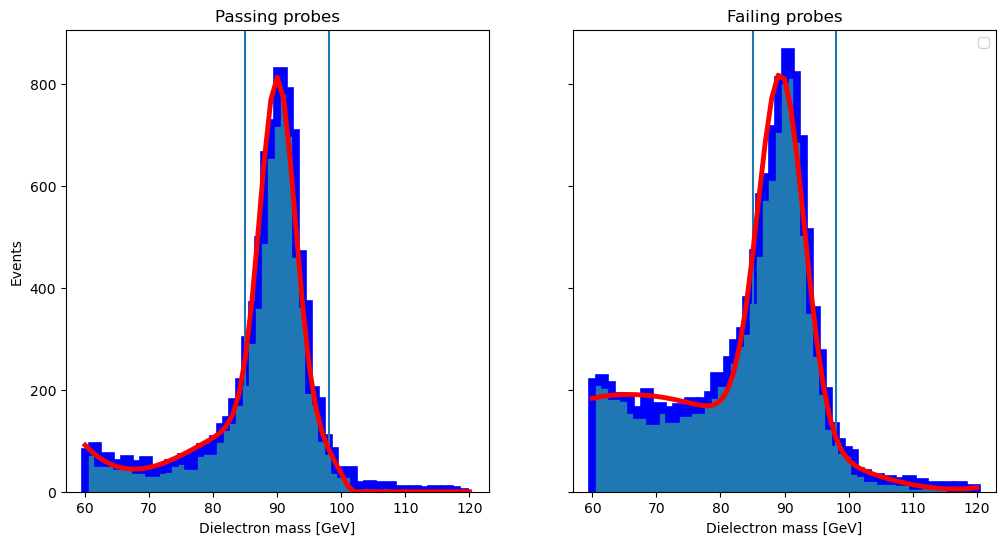

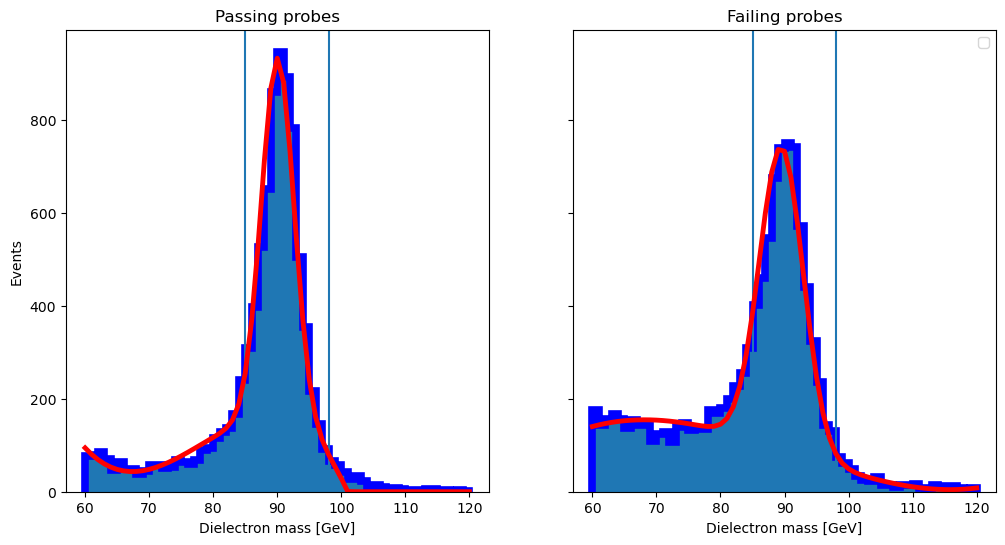

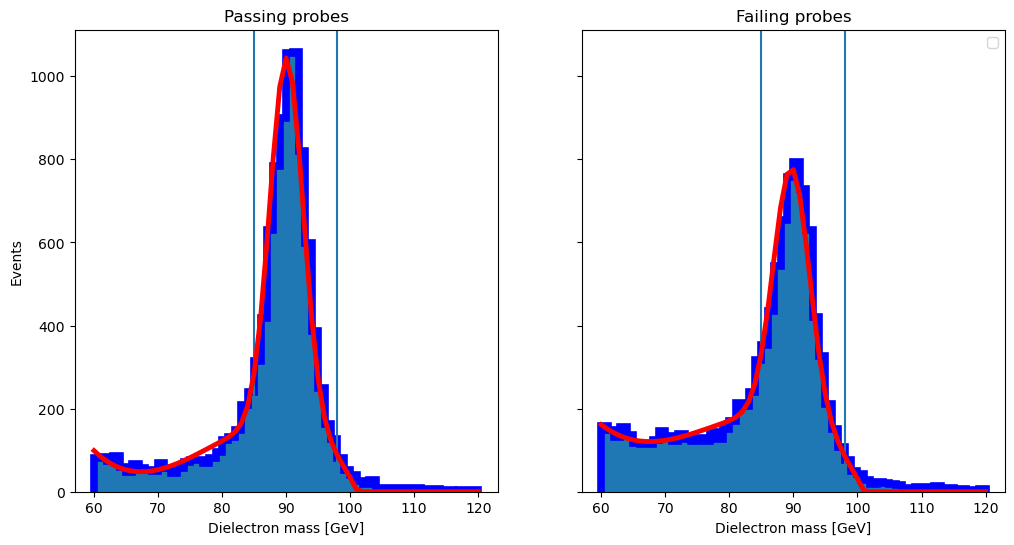

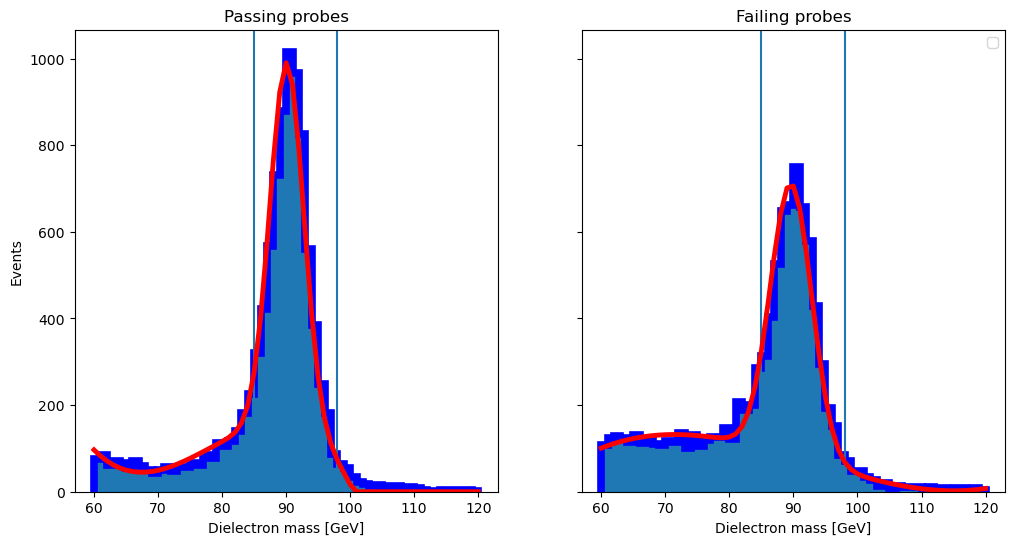

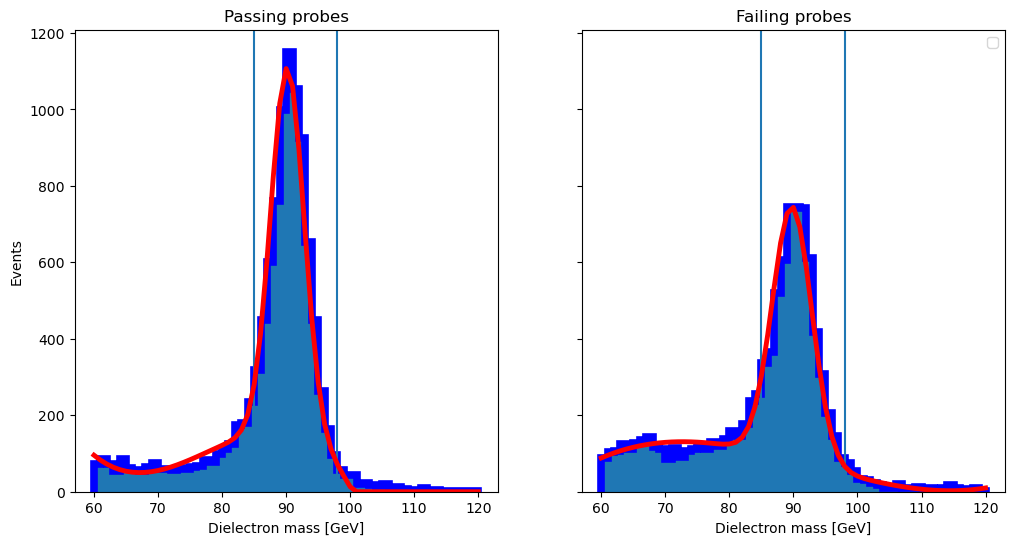

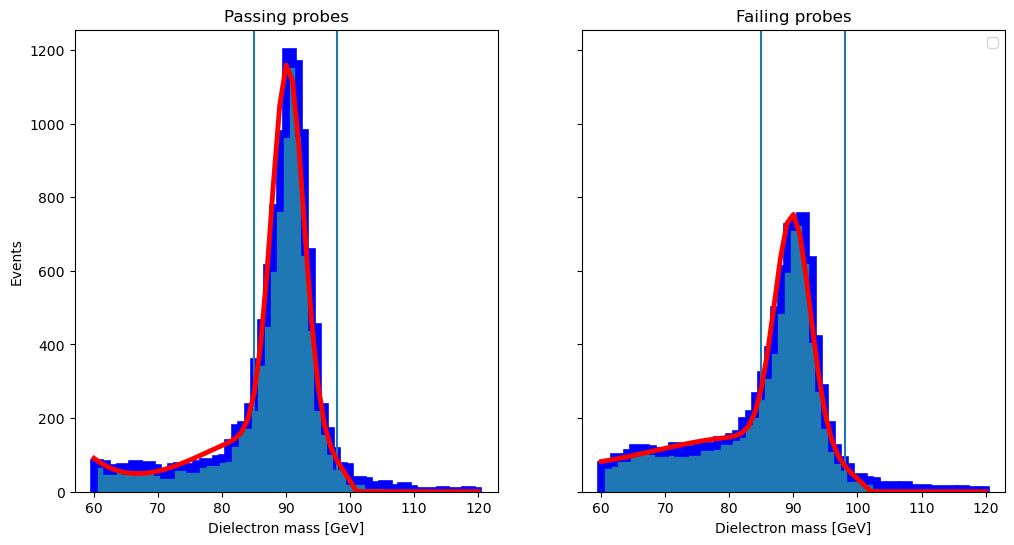

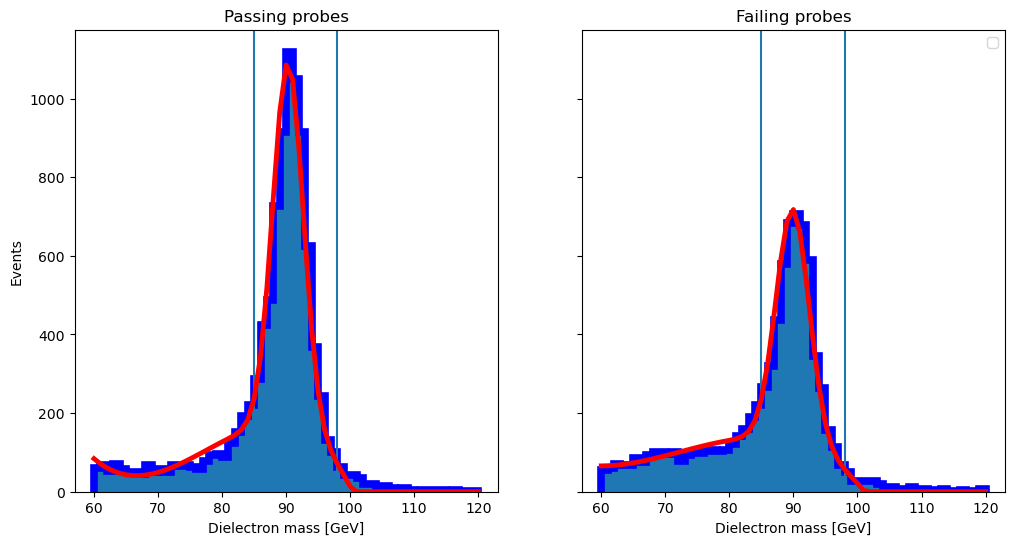

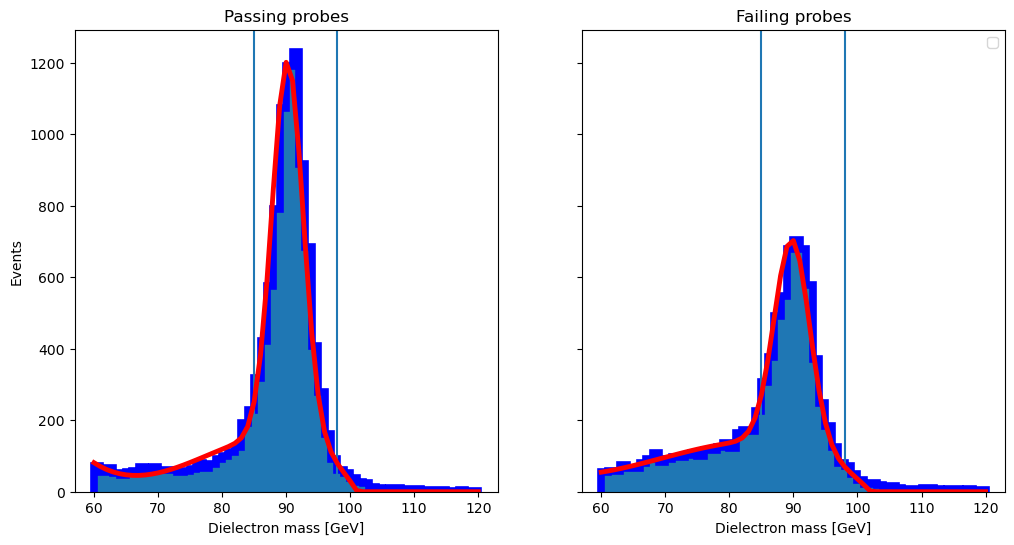

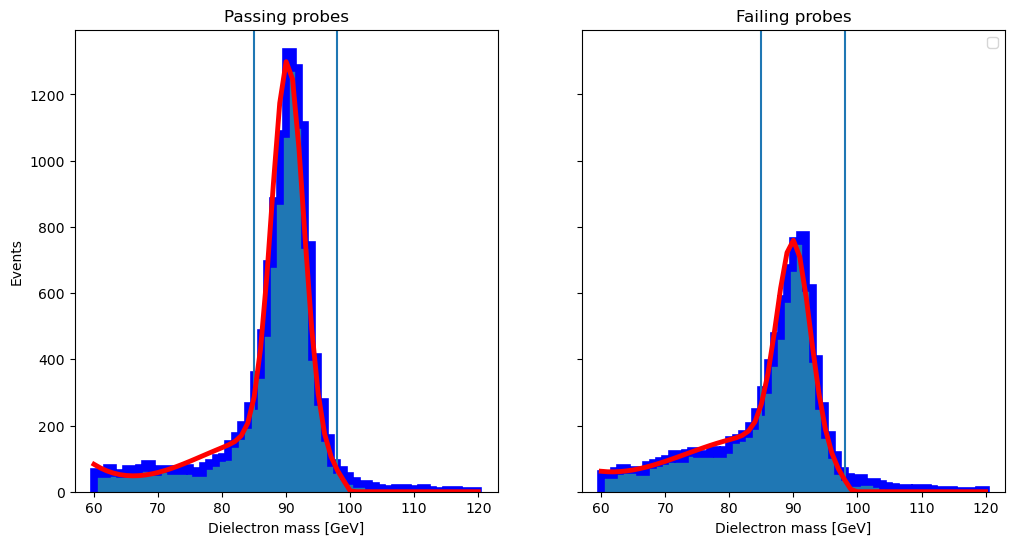

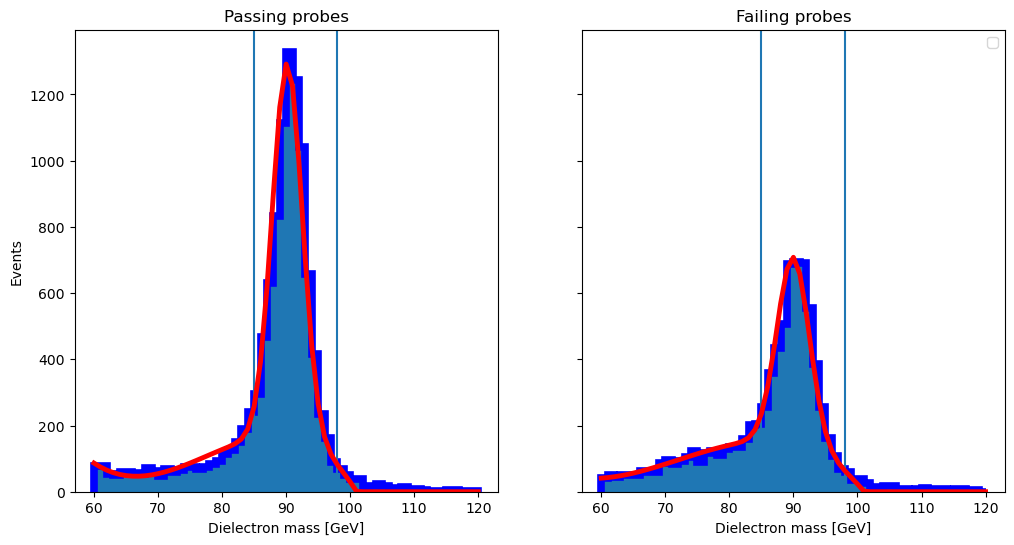

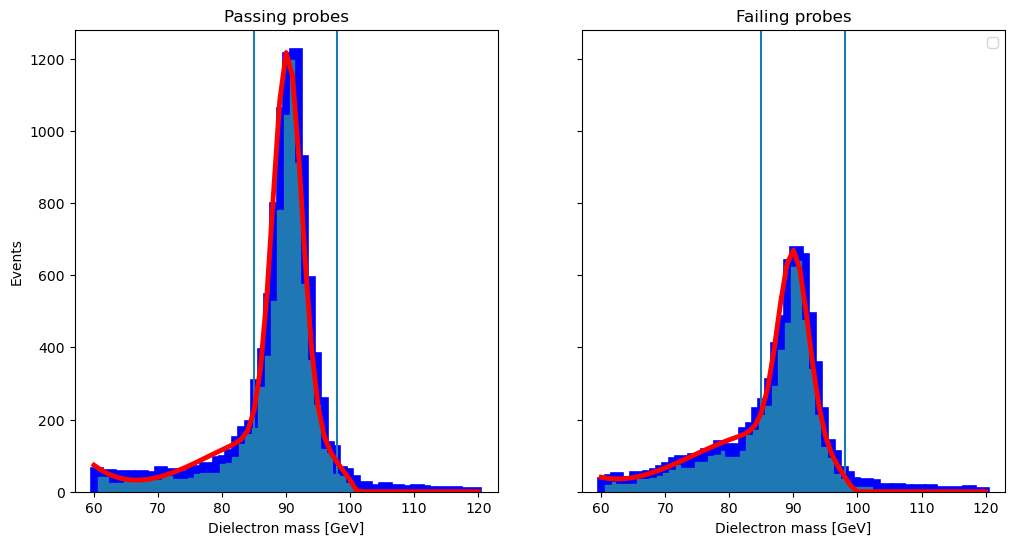

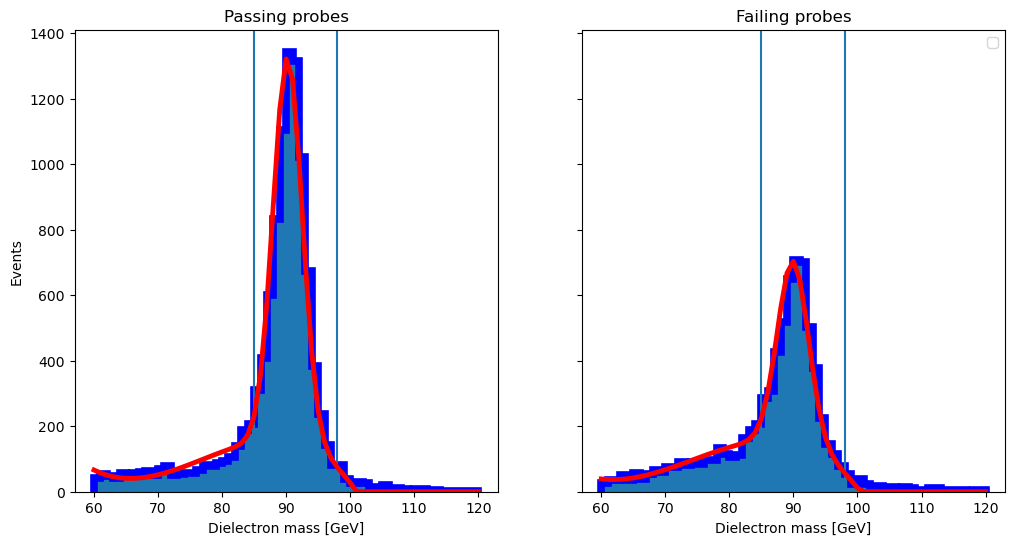

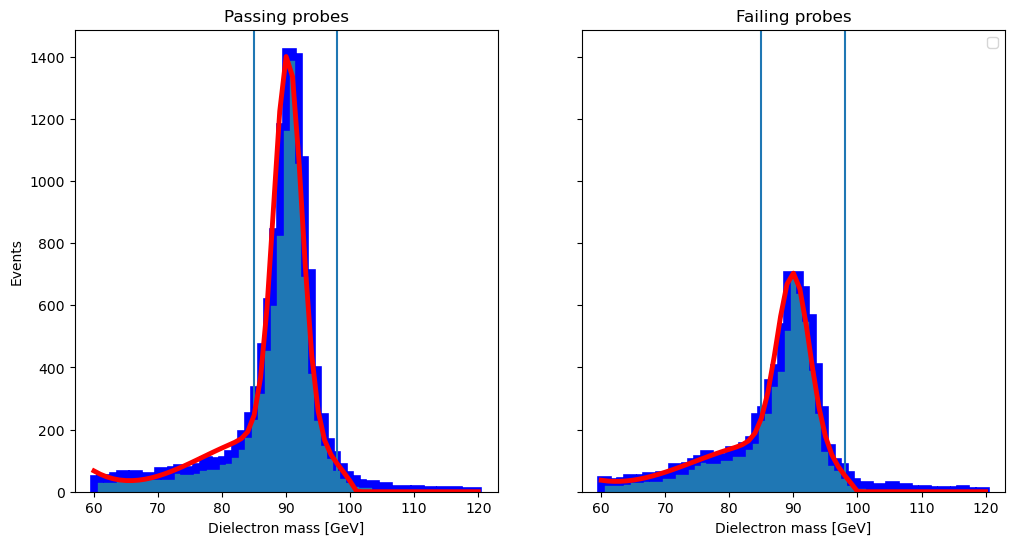

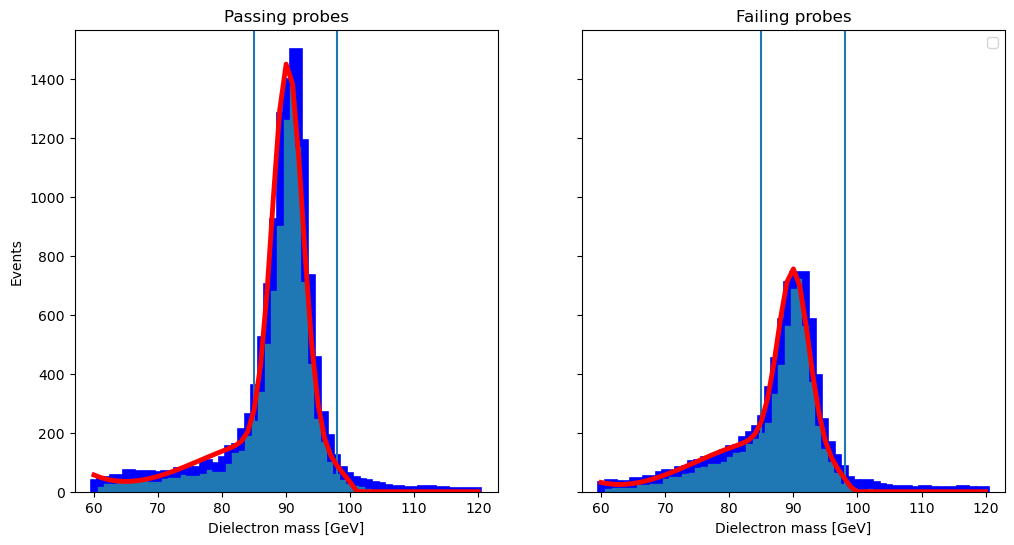

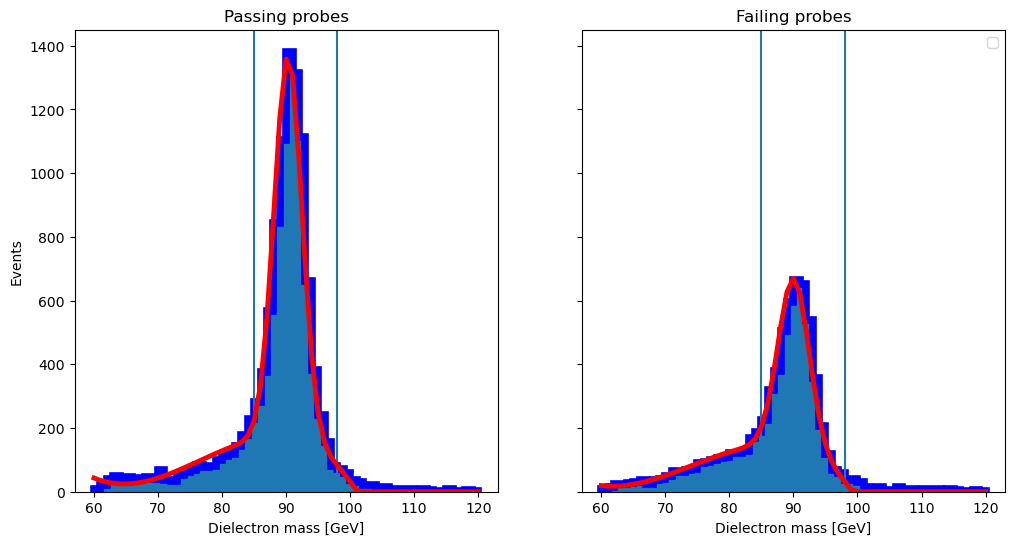

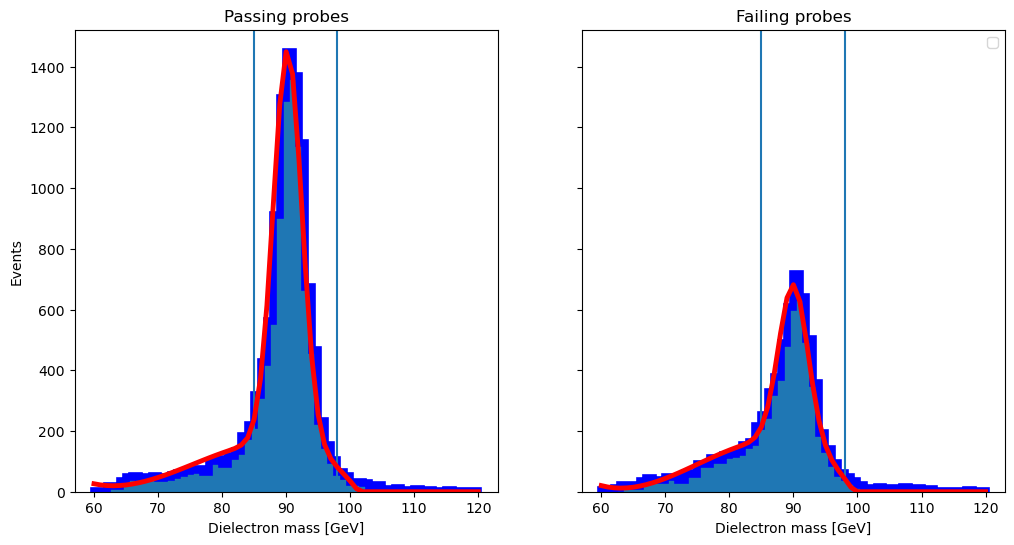

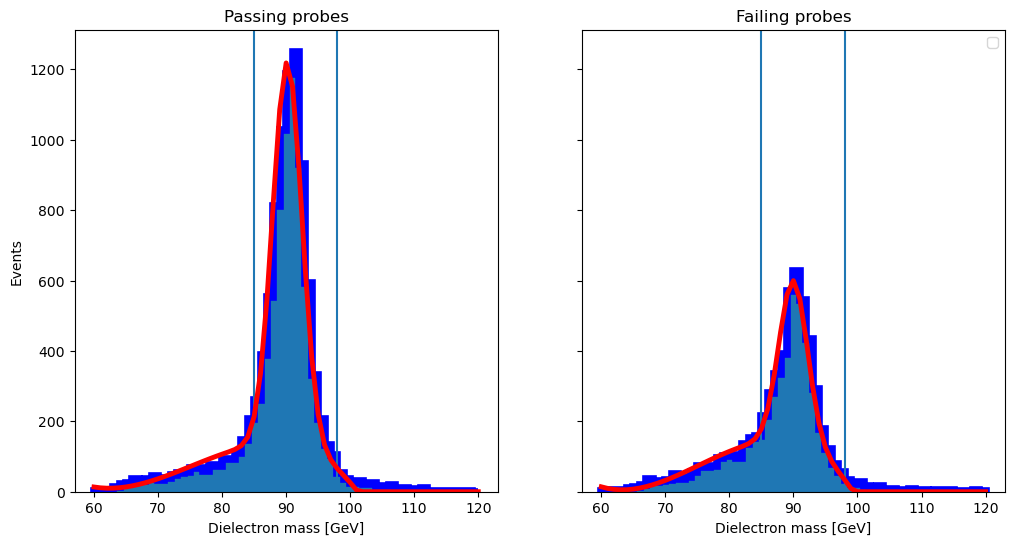

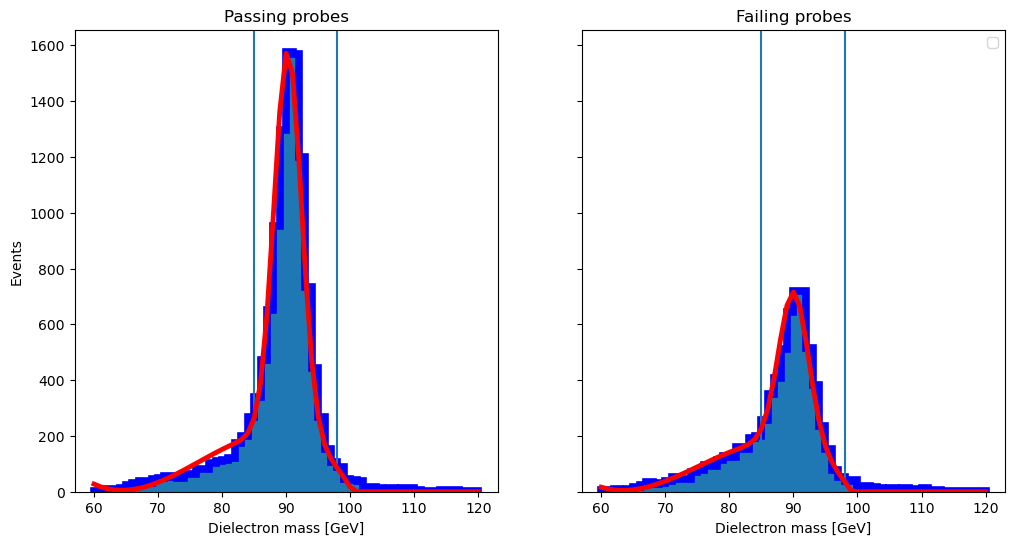

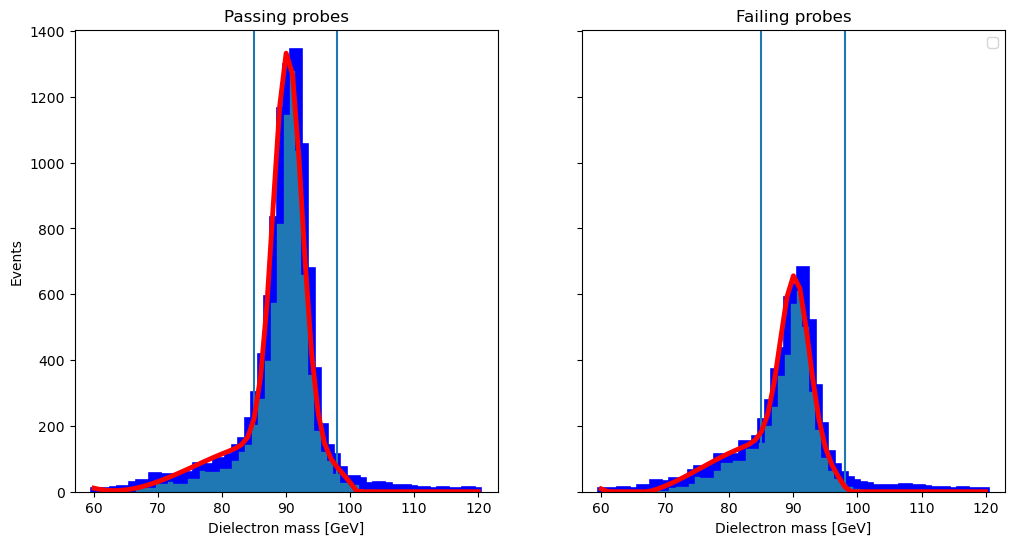

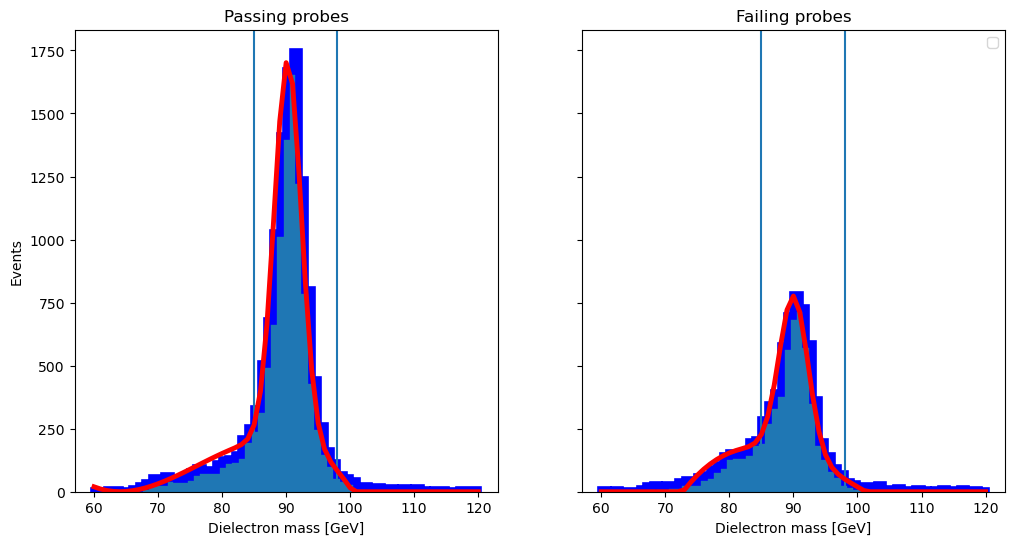

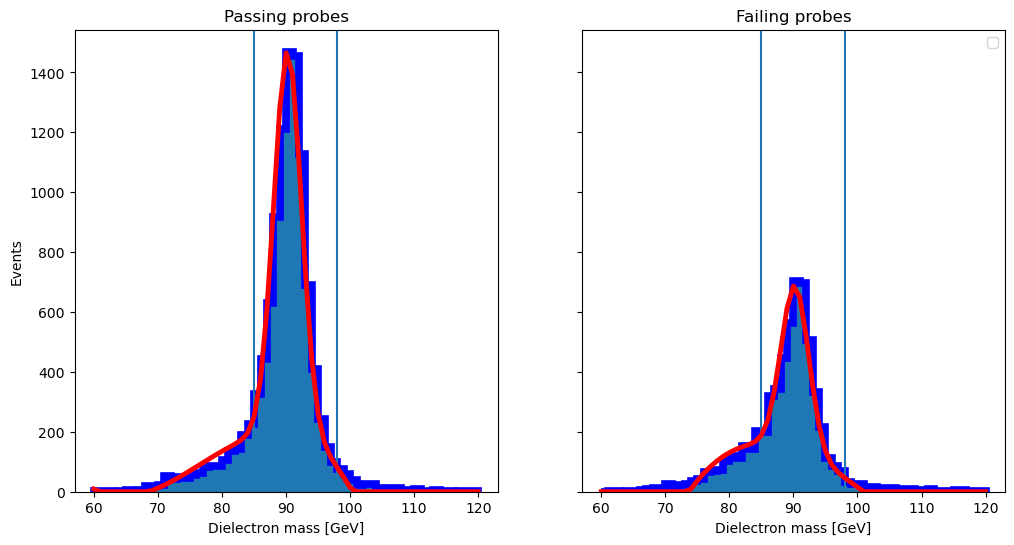

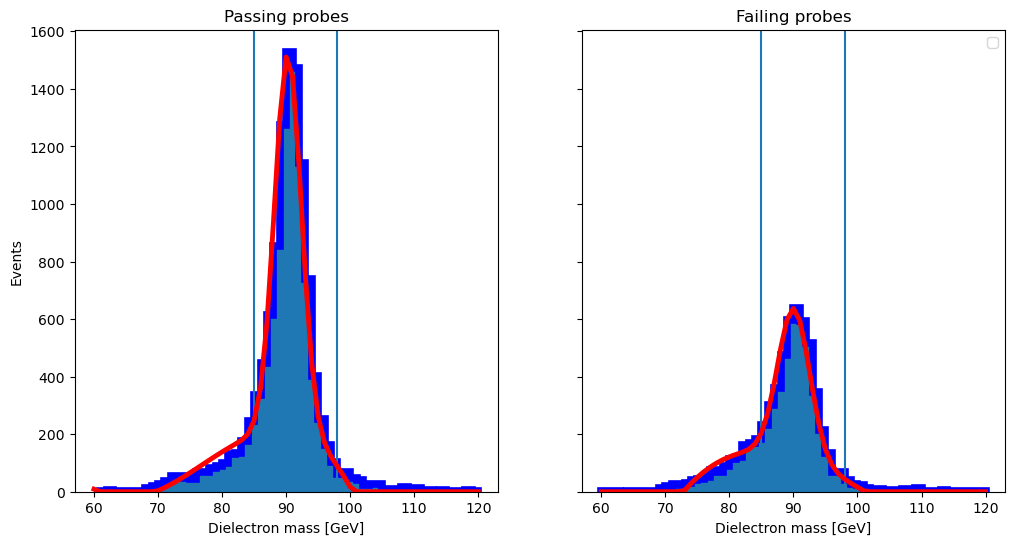

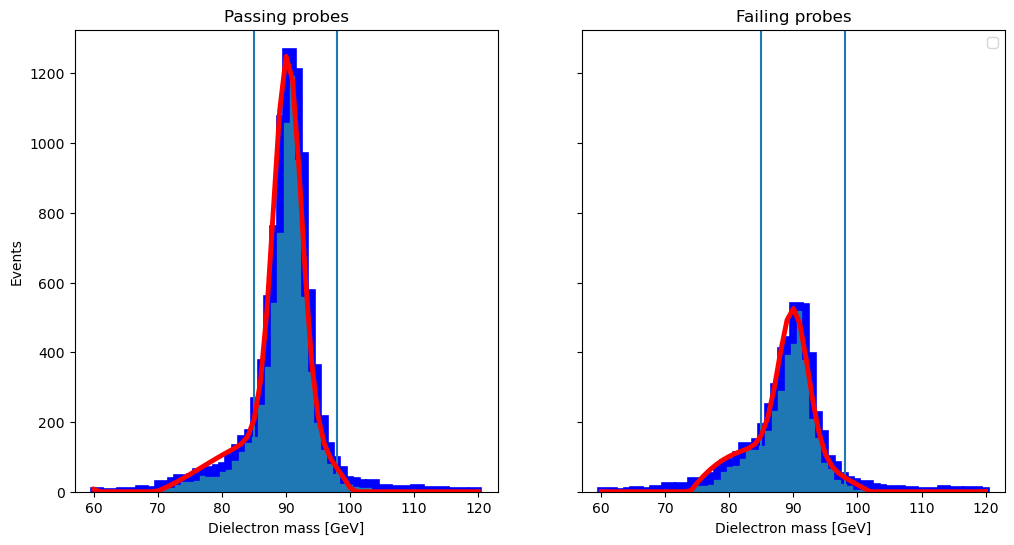

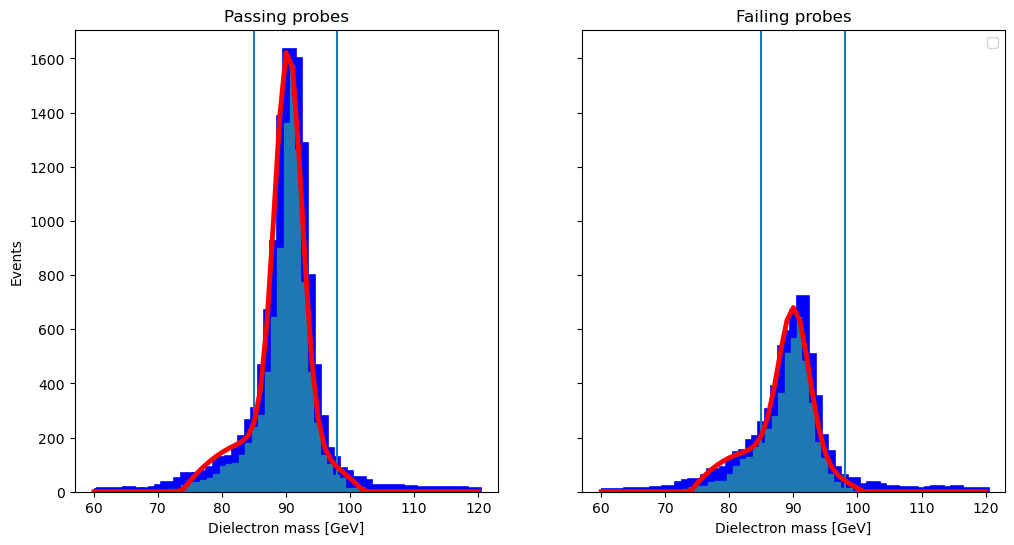

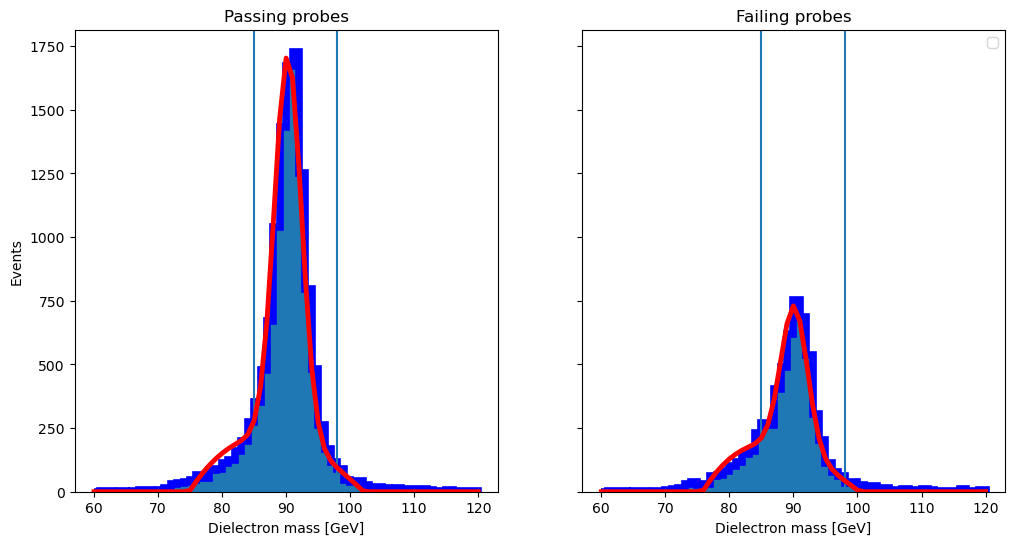

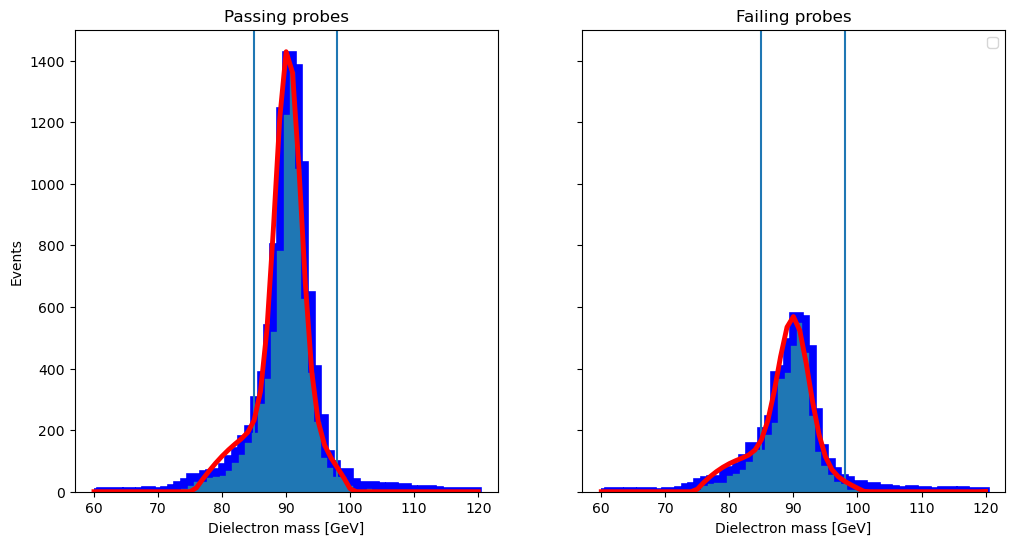

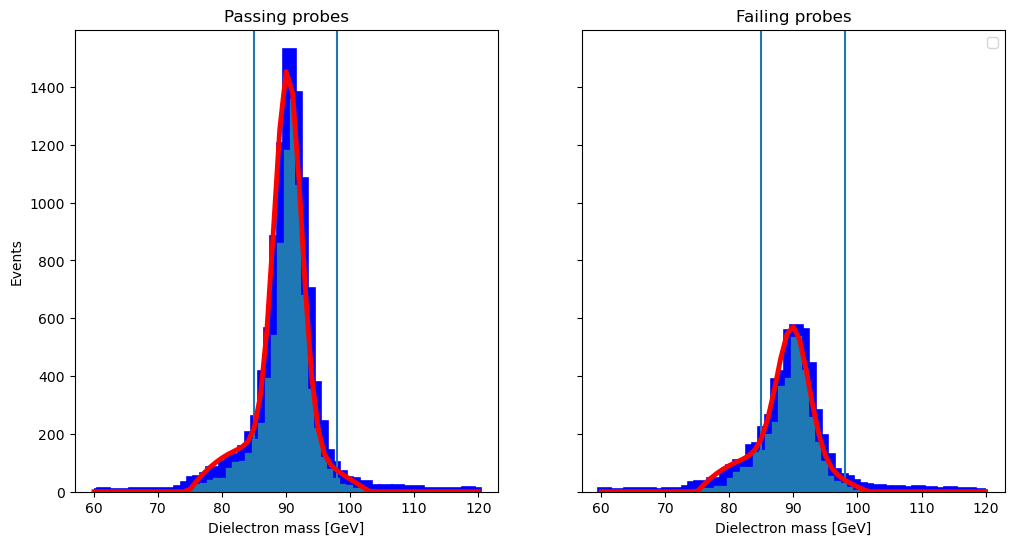

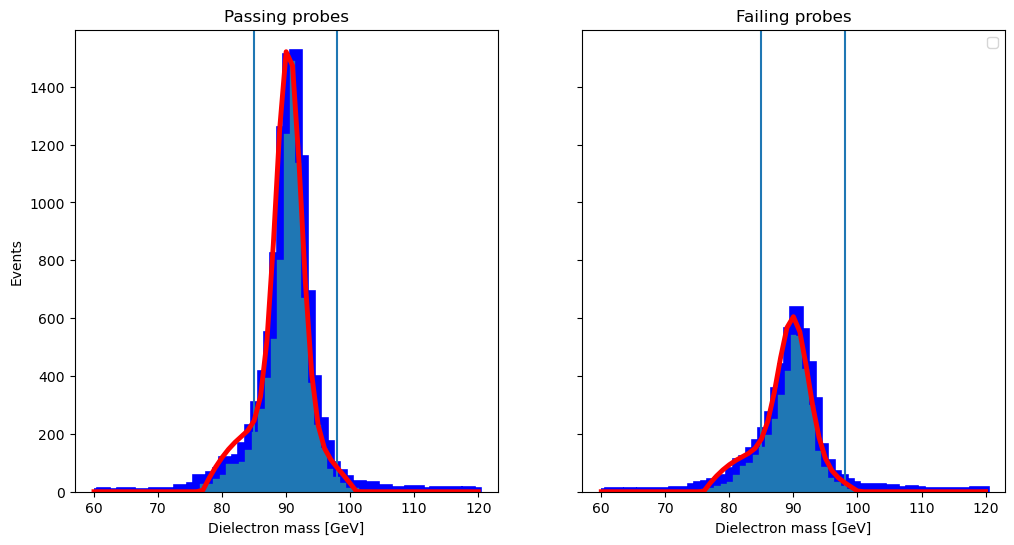

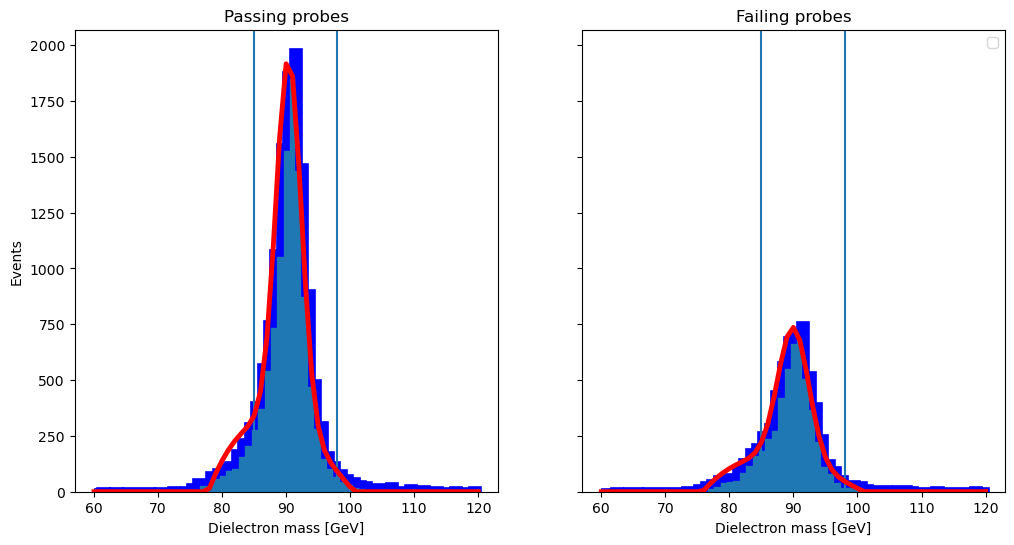

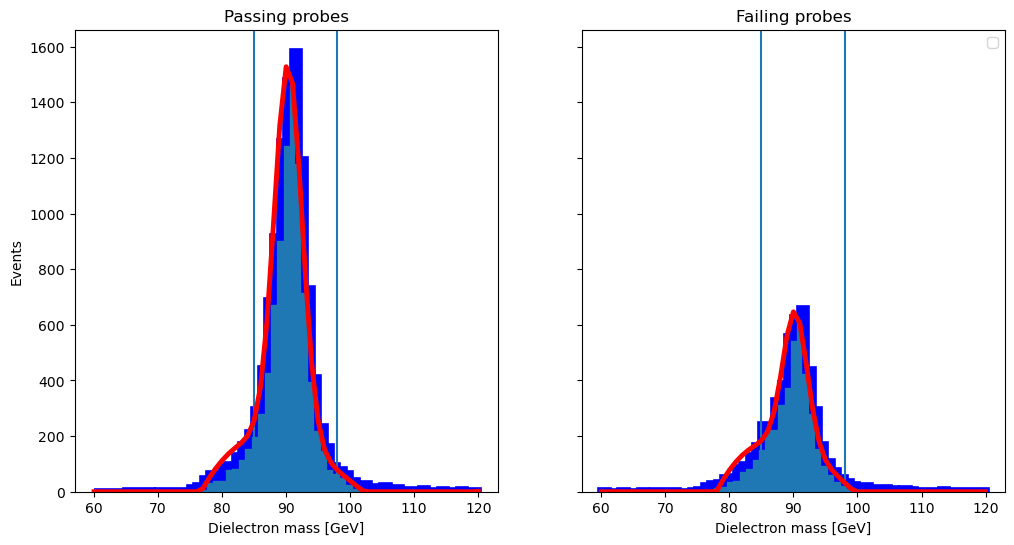

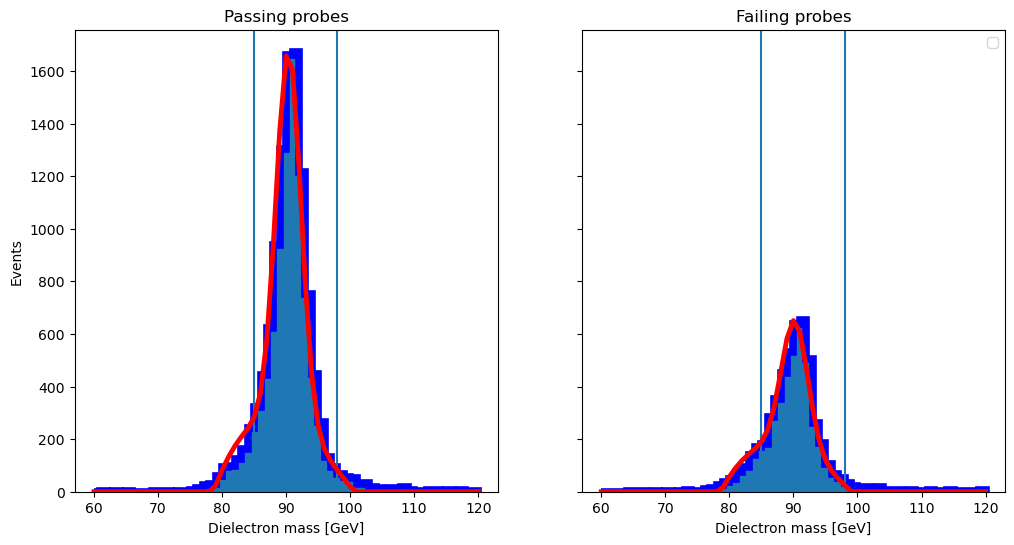

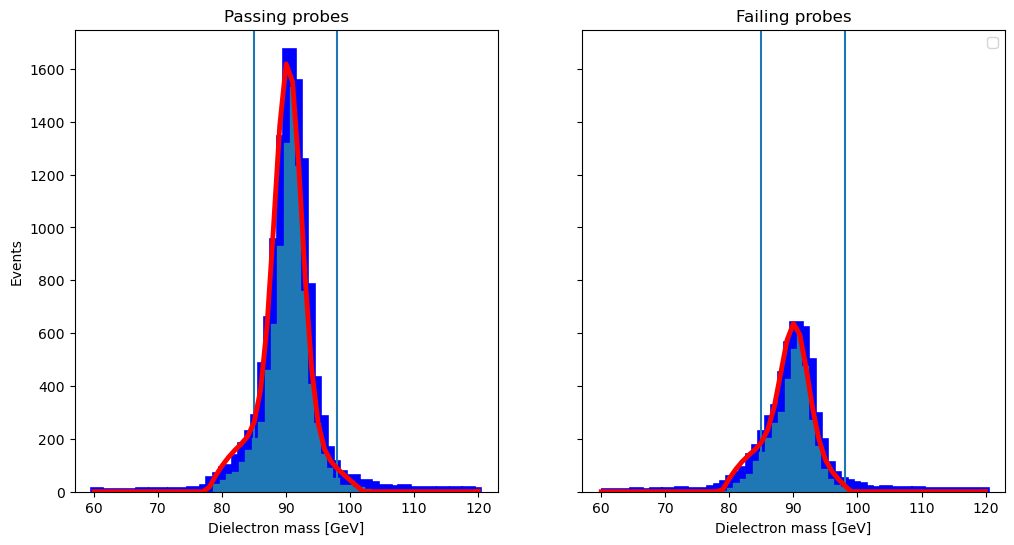

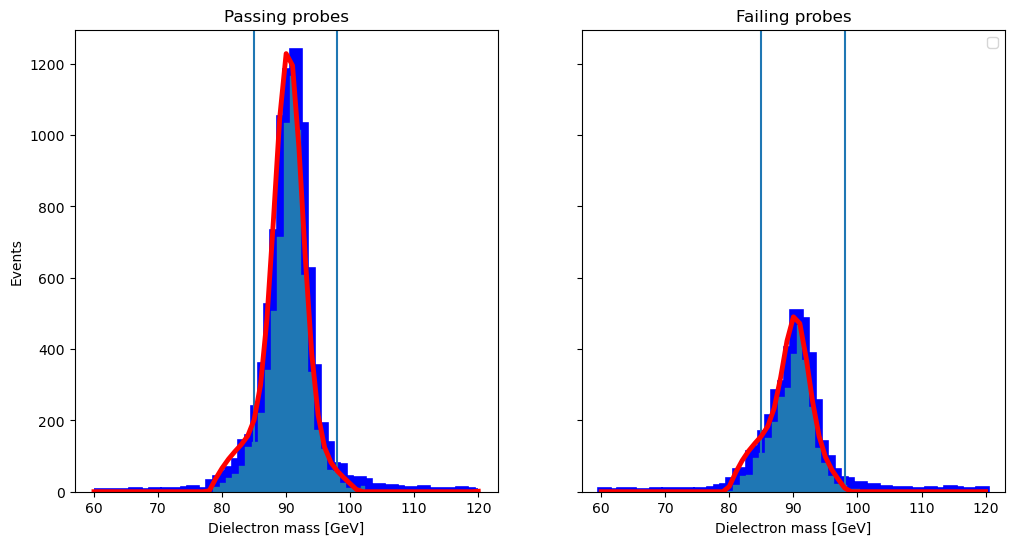

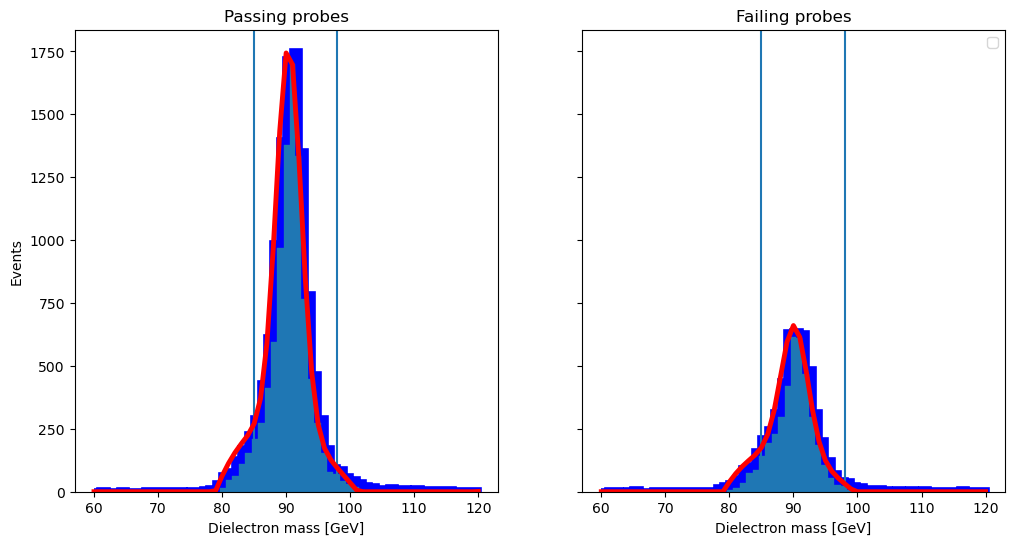

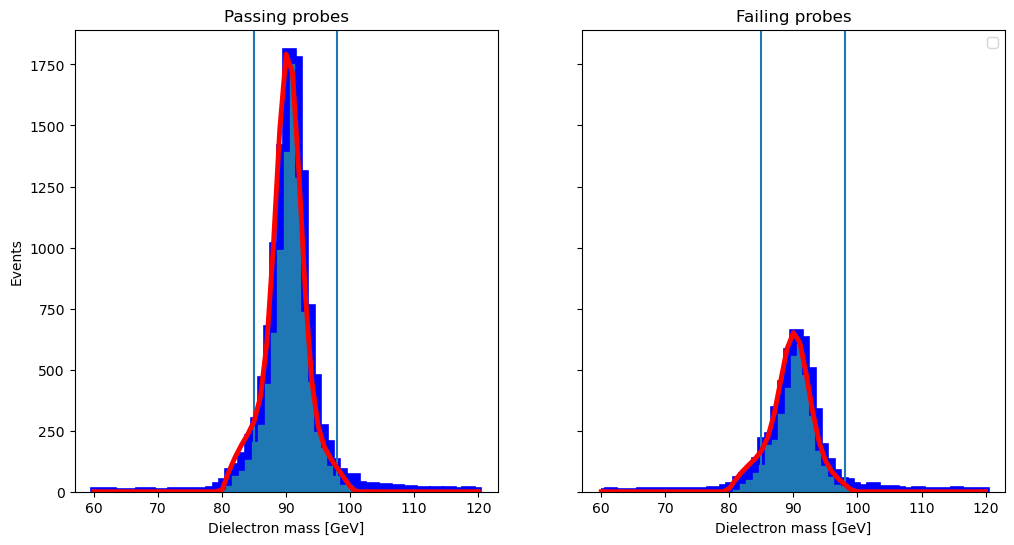

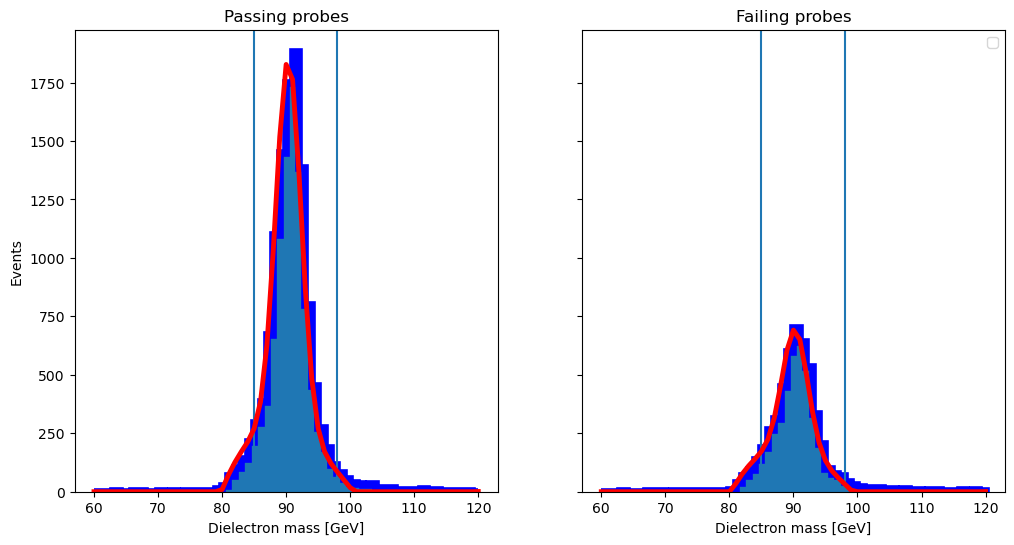

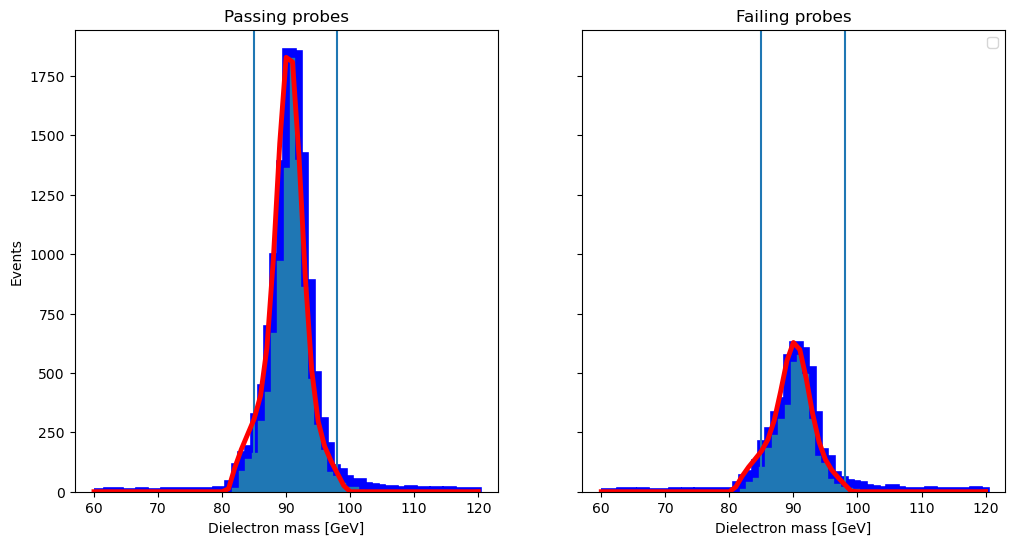

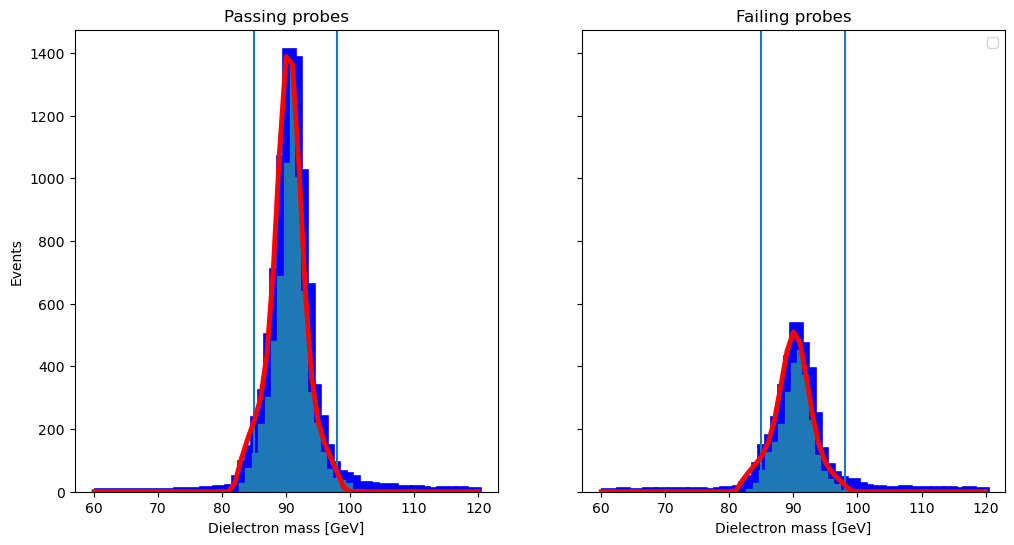

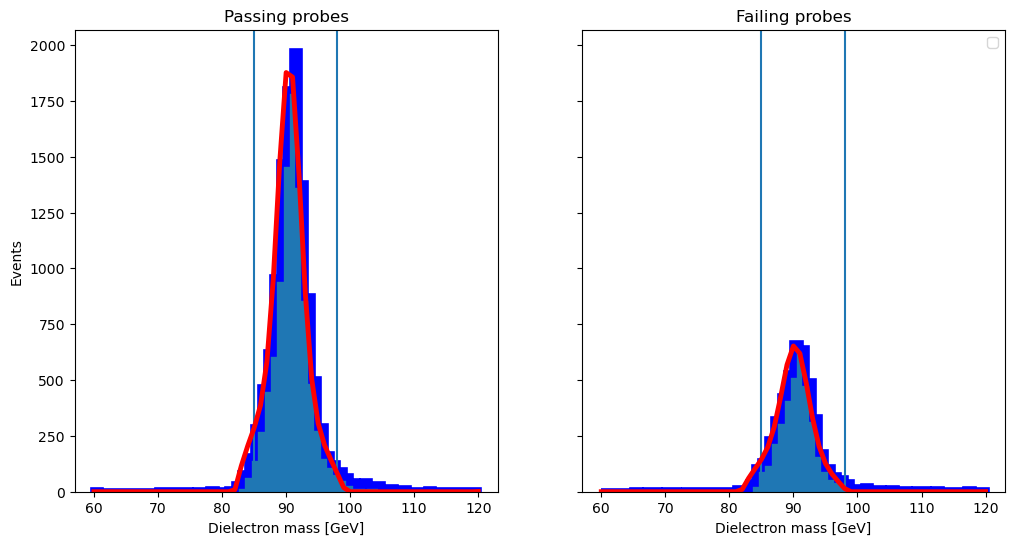

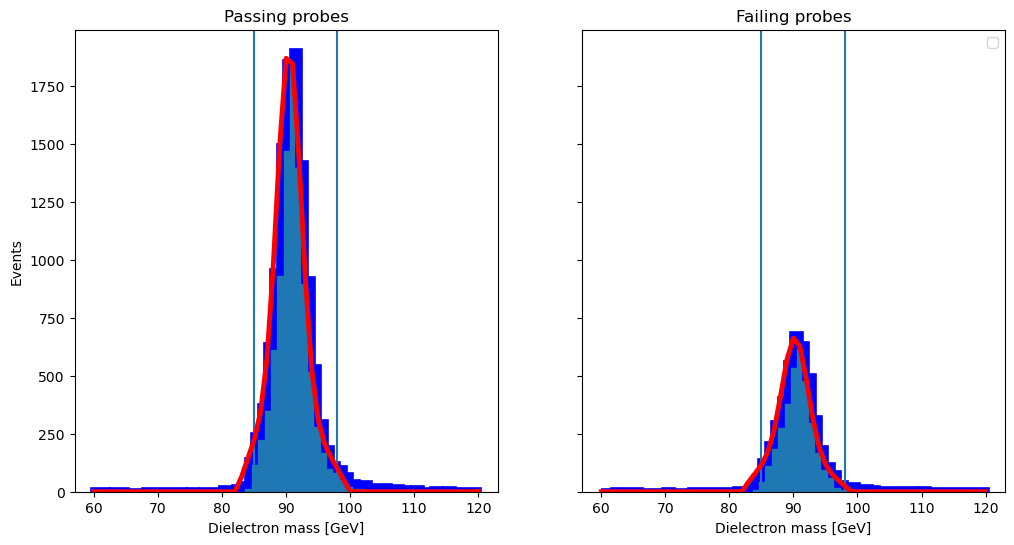

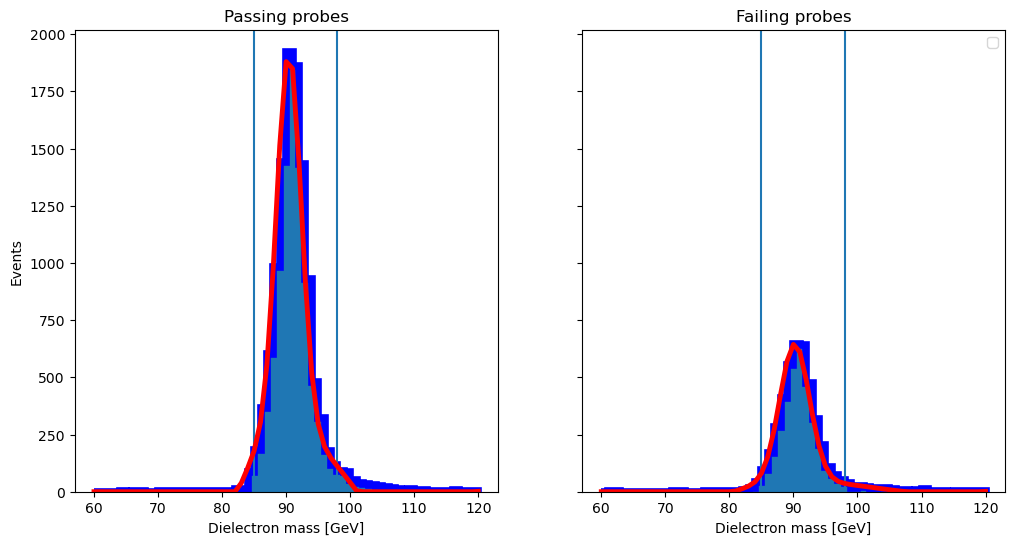

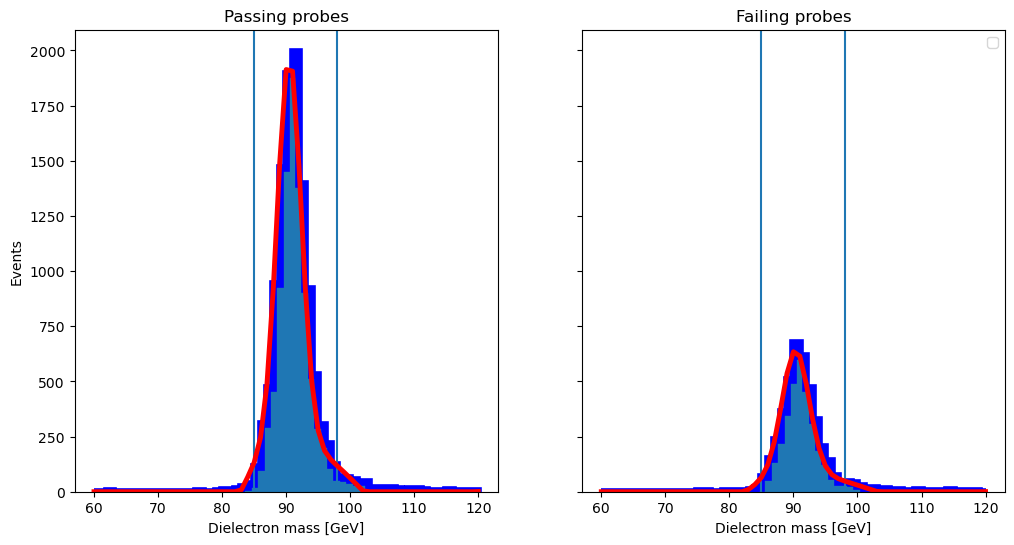

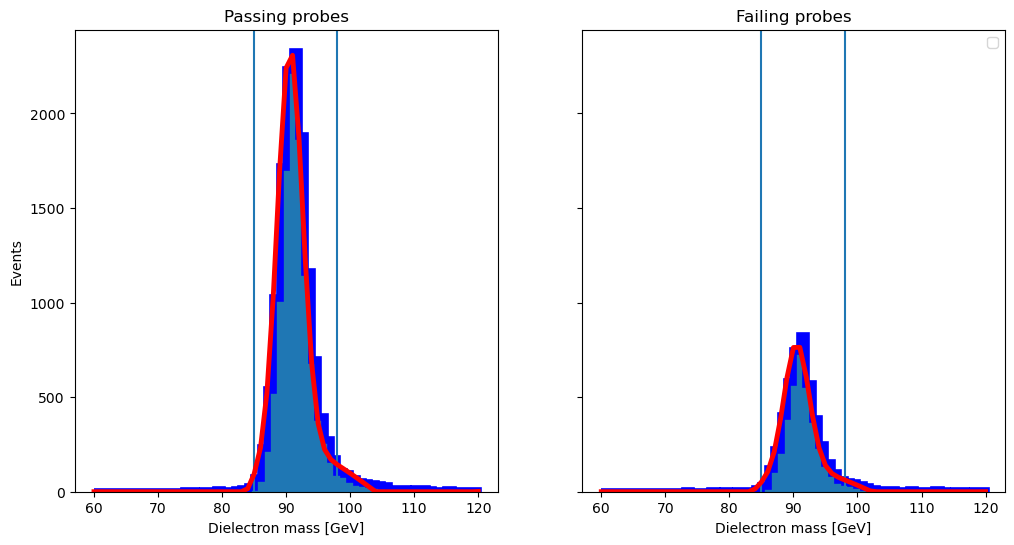

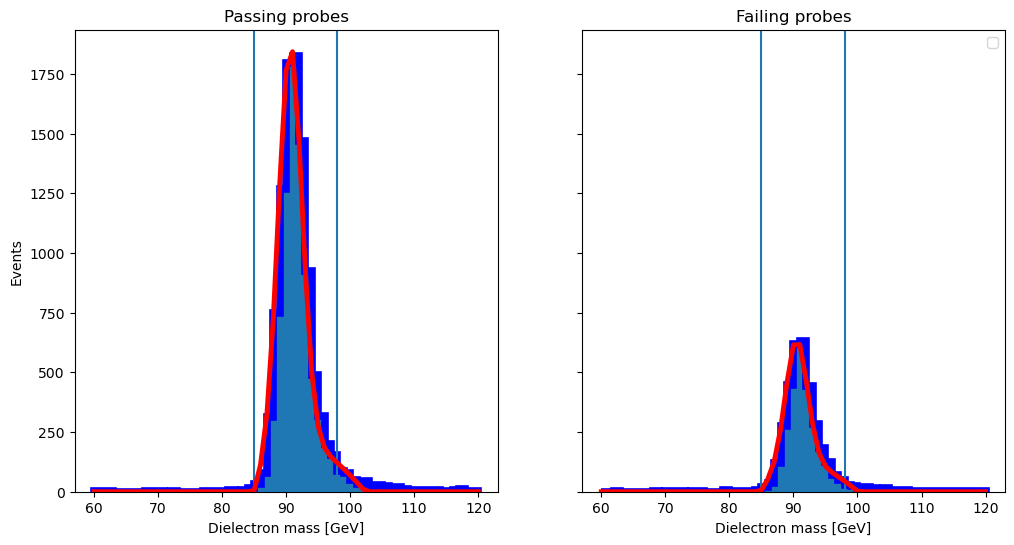

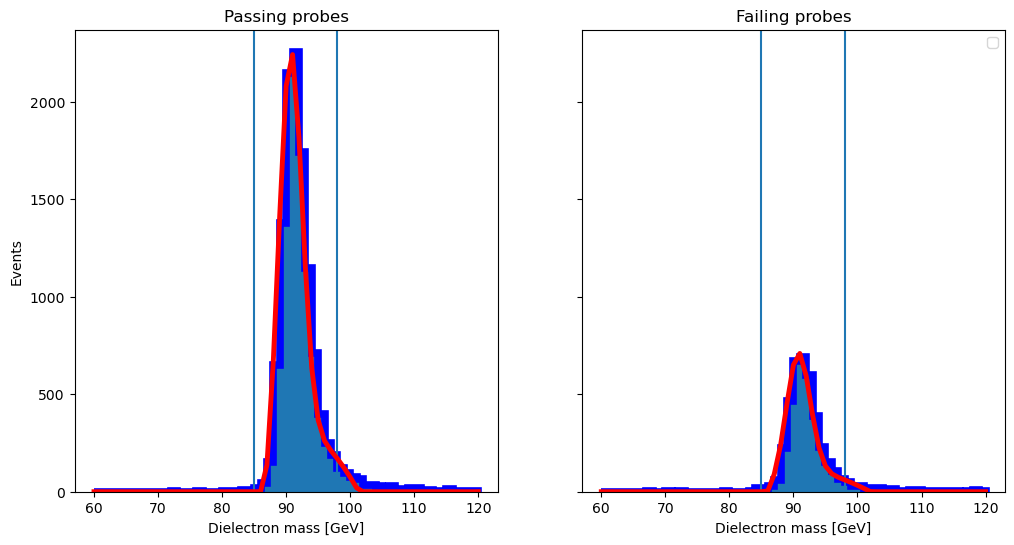

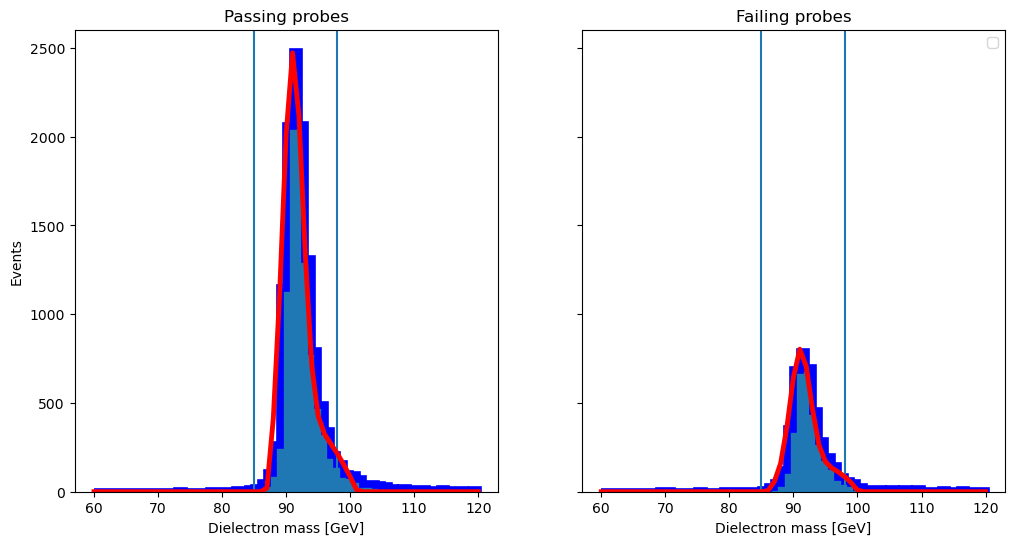

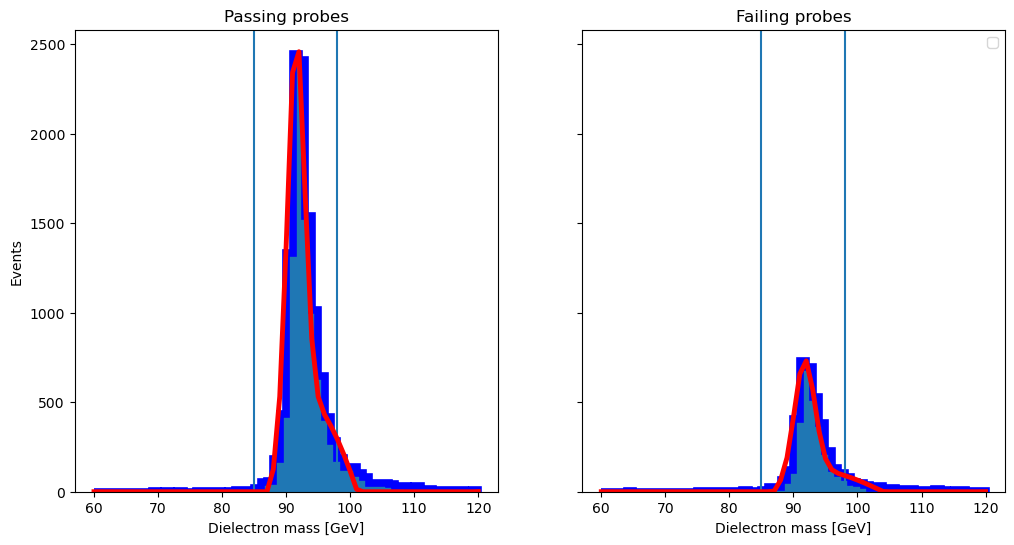

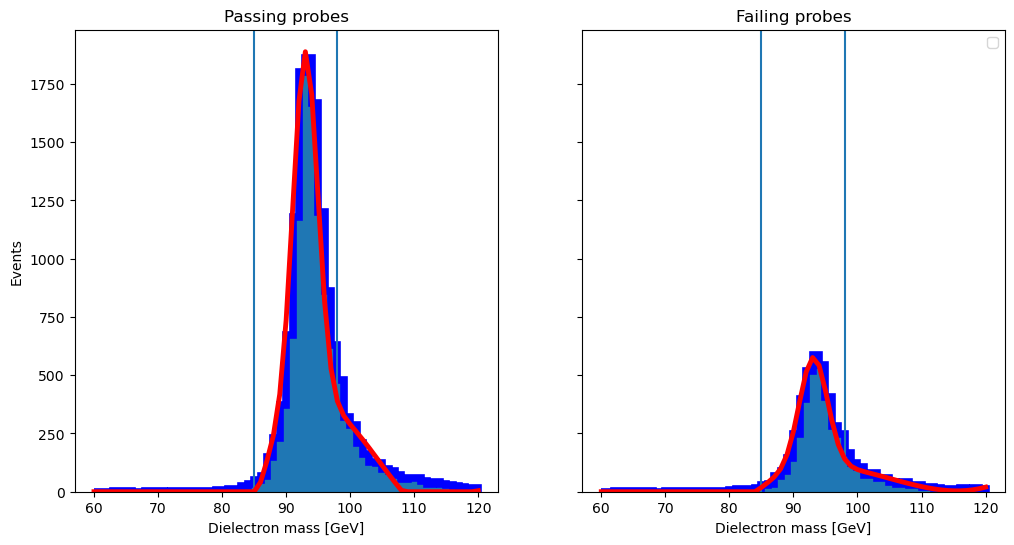

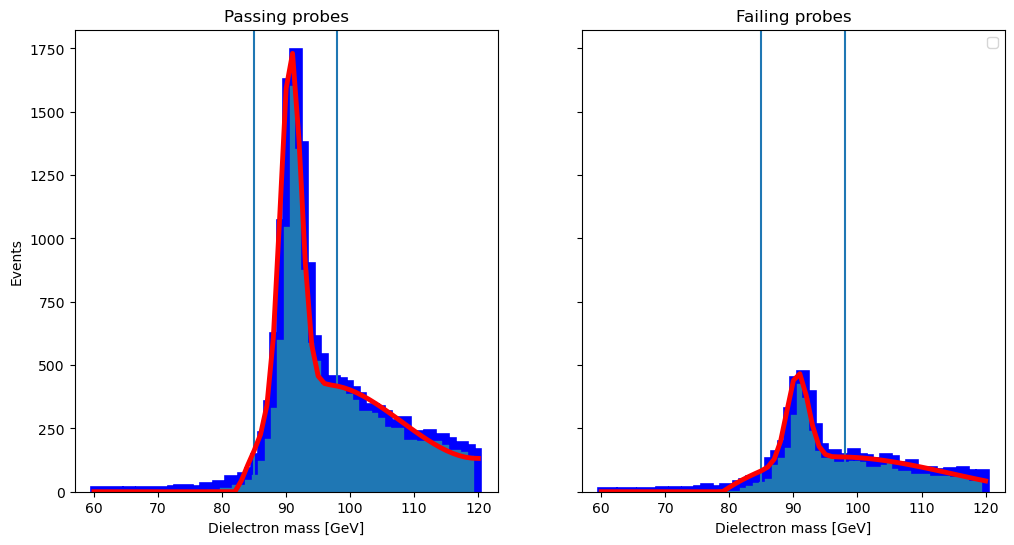

In [8]:
ptbins = np.array([  5. ,  13.6,  16.8,  18.8,  20.4,  21.7,  22.9,  24. ,  24.9,
        25.8,  26.7,  27.5,  28.2,  28.9,  29.6,  30.3,  30.9,  31.5,
        32. ,  32.6,  33.1,  33.7,  34.2,  34.7,  35.1,  35.6,  36.1,
        36.5,  36.9,  37.3,  37.8,  38.2,  38.6,  39. ,  39.3,  39.7,
        40.1,  40.5,  40.9,  41.2,  41.6,  42. ,  42.4,  42.8,  43.3,
        43.7,  44.2,  44.8,  45.6,  47.5, 303.9])
print(ptbins)
eff_per_bin = [
    tag_eff(
        zcands.mass[zcands.goodprobe & (zcands.probe_pt >= lo) & (zcands.probe_pt < hi)],
        zcands.mass[~zcands.goodprobe & (zcands.probe_pt >= lo) & (zcands.probe_pt < hi)],
    )
    for lo, hi in zip(ptbins[:-1], ptbins[1:])
]
# eff_pt20to50 = tag_eff(
#     zcands.mass[zcands.goodprobe & (zcands.probe_pt >= 20) & (zcands.probe_pt < 50)],
#     zcands.mass[~zcands.goodprobe & (zcands.probe_pt >= 20) & (zcands.probe_pt < 50)],
# )
# eff_pt50to100 = tag_eff(
#     zcands.mass[zcands.goodprobe & (zcands.probe_pt >= 50) & (zcands.probe_pt < 100)],
#     zcands.mass[~zcands.goodprobe & (zcands.probe_pt >= 50) & (zcands.probe_pt < 100)],
# )


In [11]:
eff_per_bin

[0.3291395265612416+/-0.015029001000938803,
 0.41741786244600176+/-0.012053758083379476,
 0.4692733611415076+/-0.011137151919352937,
 0.5751718257465656+/-0.013362137020281356,
 0.5216273185493921+/-0.009579174441112984,
 0.5481087480767785+/-0.00967337600665952,
 0.5919081996819505+/-0.013736160885276561,
 0.5895998695439016+/-0.01231566219126673,
 0.6164519299874952+/-0.011746041211360162,
 0.6425352065262158+/-0.013381975087225911,
 0.6491231615257482+/-0.010937021507332974,
 0.6642126283132255+/-0.010322010882978076,
 0.6644417379083395+/-0.011383107803272915,
 0.6576119157210543+/-0.01096454218278188,
 0.6833649955419991+/-0.009472289224913718,
 0.6693363672131932+/-0.010039020369383415,
 0.7092738937409637+/-0.009955079019689825,
 0.7080893334919963+/-0.010444322313030876,
 0.6991837428394372+/-0.010250194724132447,
 0.7033065632989518+/-0.01035272541455711,
 0.6930413742777976+/-0.012040083511042361,
 0.6992569060611215+/-0.013434431246888671,
 0.6813724107311107+/-0.01255369143

In [9]:
import hist.intervals
from uncertainties import ufloat

def cut(pass_mass, fail_mass):
    n_pass = np.sum((pass_mass >= 80) & (pass_mass <= 101))
    n_fail = np.sum((fail_mass >= 80) & (fail_mass <= 101))
    n_pass_unc = np.sqrt(n_pass)
    n_fail_unc = np.sqrt(n_fail)
    x = ufloat(n_pass, n_pass_unc)
    y = ufloat(n_fail, n_fail_unc)
    efficiency = x/(x+y)
    print(efficiency*100,"%")
    uncertainty = hist.intervals.ratio_uncertainty(
        np.array(n_pass),
        np.array(n_pass+n_fail),
        uncertainty_type='efficiency'
    )
    alt_efficiency = ufloat(n_pass/(n_pass+n_fail), uncertainty[0])
    print("alt",efficiency*100,"%")
    return efficiency

# Calculate the efficiency for the current bin using the cut_and_count_efficiency function
eff_bin = cut(
        zcands.mass[zcands.goodprobe & (zcands.mass >= 80) & (zcands.mass <= 101)],
        zcands.mass[~zcands.goodprobe &   (zcands.mass >= 80) & (zcands.mass <= 101)],
    )

eff_per_bin_cut = [
    cut(
        zcands.mass[zcands.goodprobe & (zcands.probe_pt >= lo) & (zcands.probe_pt < hi)],
        zcands.mass[~zcands.goodprobe & (zcands.probe_pt >= lo) & (zcands.probe_pt < hi)],
    )
    for lo, hi in zip(ptbins[:-1], ptbins[1:])
]
eff_per_bin_cut

65.08+/-0.05 %
alt 65.08+/-0.05 %
29.7+/-0.4 %
alt 29.7+/-0.4 %
44.8+/-0.4 %
alt 44.8+/-0.4 %
50.4+/-0.4 %
alt 50.4+/-0.4 %
53.5+/-0.4 %
alt 53.5+/-0.4 %
54.2+/-0.4 %
alt 54.2+/-0.4 %
56.0+/-0.4 %
alt 56.0+/-0.4 %
57.1+/-0.4 %
alt 57.1+/-0.4 %
57.5+/-0.4 %
alt 57.5+/-0.4 %
58.7+/-0.4 %
alt 58.7+/-0.4 %
59.9+/-0.4 %
alt 59.9+/-0.4 %
60.7+/-0.4 %
alt 60.7+/-0.4 %
60.7+/-0.4 %
alt 60.7+/-0.4 %
61.2+/-0.4 %
alt 61.2+/-0.4 %
62.0+/-0.4 %
alt 62.0+/-0.4 %
62.7+/-0.4 %
alt 62.7+/-0.4 %
63.1+/-0.4 %
alt 63.1+/-0.4 %
63.9+/-0.4 %
alt 63.9+/-0.4 %
63.8+/-0.4 %
alt 63.8+/-0.4 %
64.5+/-0.4 %
alt 64.5+/-0.4 %
64.2+/-0.4 %
alt 64.2+/-0.4 %
64.8+/-0.4 %
alt 64.8+/-0.4 %
65.2+/-0.4 %
alt 65.2+/-0.4 %
65.7+/-0.4 %
alt 65.7+/-0.4 %
66.5+/-0.4 %
alt 66.5+/-0.4 %
66.4+/-0.4 %
alt 66.4+/-0.4 %
67.1+/-0.4 %
alt 67.1+/-0.4 %
67.5+/-0.4 %
alt 67.5+/-0.4 %
66.9+/-0.4 %
alt 66.9+/-0.4 %
67.4+/-0.4 %
alt 67.4+/-0.4 %
68.27+/-0.34 %
alt 68.27+/-0.34 %
68.5+/-0.4 %
alt 68.5+/-0.4 %
68.8+/-0.4 %
alt 68.8+/-0.4 %
69

[0.2971078555190705+/-0.0036314382662426333,
 0.4482649642879717+/-0.003953809261761906,
 0.5036308423554264+/-0.0040623833653813425,
 0.5346782783033645+/-0.003948143096256983,
 0.5419643453295052+/-0.004071201390077325,
 0.5595982565851809+/-0.0039455587703113556,
 0.5708530059804847+/-0.003927096506527286,
 0.5751918689068658+/-0.00411030061811601,
 0.5865664874668048+/-0.003963253741815309,
 0.5988252391909895+/-0.0038140880029630727,
 0.6071908387179323+/-0.0039062499366101407,
 0.6070485193938552+/-0.004072031593294358,
 0.6115041928721174+/-0.003945106293156636,
 0.6201920060237184+/-0.0038445175375059616,
 0.6269196560924992+/-0.0037240367217221894,
 0.6313924727588742+/-0.003944396082045537,
 0.6388055892298858+/-0.003836885131648518,
 0.6377752892870474+/-0.004152900466130621,
 0.6451747584396994+/-0.003695142630470945,
 0.6417817248317491+/-0.003993837118243717,
 0.6475395879448322+/-0.0035991314355810836,
 0.652050919377652+/-0.003819245320118987,
 0.6565708091564114+/-0.00

In [10]:
eff_per_bin_cut[0].std_dev

0.0036314382662426333

In [11]:
import jax
from jax import config
config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax.scipy.special import erf
from jax.scipy import stats as jstats
from scipy import stats
from scipy.optimize import minimize
import iminuit
from scipy.special import expit, logit

In [12]:
cut = (zcands.mass >= 81) & (zcands.mass <= 101)
pt_samp = np.array(zcands.probe_pt[cut])
pass_samp = np.array(zcands.goodprobe[cut])
# np.unique(pass_samp, return_counts=True)


In [13]:
jnp.l()

AttributeError: module 'jax.numpy' has no attribute 'l'

In [18]:
# import jax
# from jax import config
# config.update("jax_enable_x64", True)
# import jax.numpy as jnp
# from jax.scipy.special import erf
# from jax.scipy import stats as jstats
# from scipy import stats
# from scipy.optimize import minimize
# import iminuit
# from scipy.special import expit, logit


def p_pt_erfmodel(pt, param):
    turnon, width, plateau_eff = param
    P = plateau_eff * 0.5*(erf( (pt-turnon)/width ) + 1)
#     p = jnp.clip(p, 1e-4, 1 - 1e-4)
    # print(f"P({param}) = {p}")
    return P


def p_pt_polymodel(pt, param):
    z = jnp.zeros_like(pt)
    for i, p in enumerate(param):
        z = z + p*jnp.polyval(P.cast(T.basis(i)).coef, scale(pt))
    P = 1/(1+jnp.exp(-z))
    # print(f"P({param}) = {p}")
    return P

p_pt = p_pt_polymodel
init_param = jnp.zeros(10).at[1].add(3)
# p_pt = p_pt_erfmodel
# init_param = np.array([10., 20., 0.8])

def nll(param):
    return -jstats.bernoulli.logpmf(
        k=pass_samp,
        P=p_pt(pt_samp, param),
    ).sum()


fit = iminuit.minimize(
    nll,
    init_param,
    jac=jax.grad(nll),
)
# fit2 = minimize(
#     jax.value_and_grad(nll),
#     fit.x,
#     jac=True,
# )
fit

UnboundLocalError: local variable 'P' referenced before assignment

NameError: name 'fit' is not defined

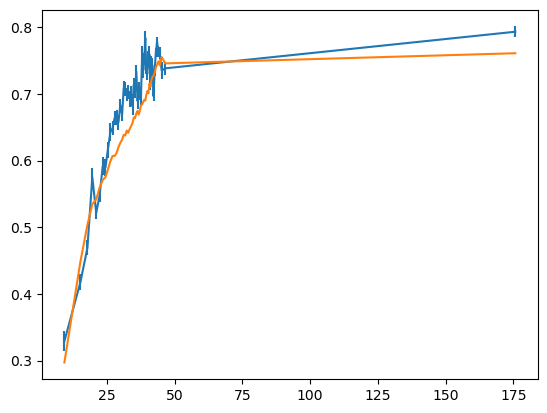

In [15]:
fig, ax = plt.subplots()

bincenters = 0.5 * (ptbins[:-1] + ptbins[1:])
ax.errorbar(
    x=bincenters,
    y=[x.nominal_value for x in eff_per_bin],
    yerr=[x.std_dev for x in eff_per_bin],
    label="Traditional fit"
)
ax.errorbar(x=bincenters, y=[x.nominal_value for x in eff_per_bin_cut], label="Cut & count")

pt = np.linspace(0, 200, 50)
ax.plot(pt, p_pt(pt, fit.x), color="g", label="Unbinned fit")
samples = stats.multivariate_normal(mean=fit.x, cov=fit.hess_inv).rvs(100)
for s in samples:
    ax.plot(pt, p_pt(pt, s), color="g", alpha=0.2, linewidth=1)

ax.scatter(pt_samp[::100], y=pass_samp[::100], color="k", alpha=0.1, label="(pt,pass) samples")

ax.legend(title="Efficiency estimate method")
ax.set_xlim(0, 60)
fig.savefig("name_of_figure.png")

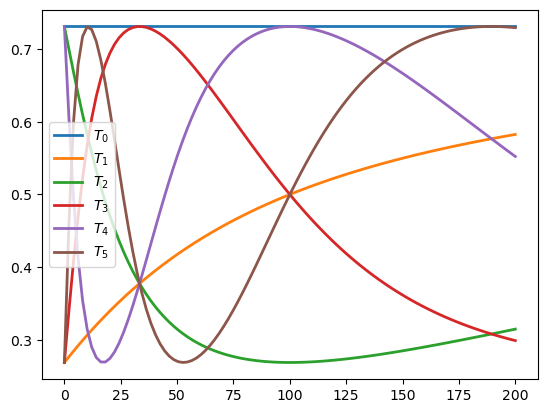

In [32]:
from numpy.polynomial import Chebyshev as T
from numpy.polynomial import Polynomial as P

def scale(pt):
    # return (pt - 100)/100
    return 2.0 * pt / (100.0 + pt) - 1

fig, ax = plt.subplots()

pt = np.linspace(0, 200, 100)
for i in range(6):
    z = T.basis(i)(scale(pt))
    ax.plot(pt, 1/(1+np.exp(-z)), lw=2, label=f"$T_{i}$")
ax.legend()

In [1]:
from coffea.nanoevents import NanoEventsFactory
import awkward as ak
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import mplhep
# mplhep.set_style(mplhep.style.CMS)

cachefile = "lab03.parquet"
if not os.path.exists(cachefile):
    zcands = ak.concatenate([
        load_zcands(filename)
        for filename in tqdm(glob.glob("Downloads/nano*.root"))
    ])
    ak.to_parquet(zcands, cachefile)
zcands = ak.from_parquet(cachefile)

def pdf(x, a, b, c, n, mu, sigma, d):
        # background = a + b*x + c*(x**2)
        background = np.polyval([a, b, c, d], x)
        signal = n*norm.pdf(x=x, loc=mu, scale=sigma)
        # np.exp(-0.5*(x-mu)**2/sigma**2)/np.sqrt(2*np.pi)/sigma
        return np.maximum(signal + background, 0)